In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import glob, os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.decomposition import PCA
import statsmodels.api as sm


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1- Importation des données et nettoyage des données

In [3]:
# import des données de consommation de puissance et stockage dans un dataframe

path = '/content/drive/MyDrive/Colab Notebooks/household_consumption'
all_files = sorted(glob.glob(os.path.join(path,"*csv")))
#for file in all_files:
#  print(file)

pow_cons = (pd.read_csv(f, sep =';', header = None) for f in all_files)
all_pow_cons = pd.concat(pow_cons)
all_pow_cons.head()

all_pow_cons[0] = pd.to_datetime(all_pow_cons.pop(0))+pd.to_timedelta(all_pow_cons.pop(1))
all_pow_cons.index = all_pow_cons[0]
all_pow_cons.drop(columns=[0], inplace=True)
all_pow_cons.columns= ['global_active power', 'global_reactive_power', 'voltage' , 'global_intensity', 'sub-metering_1', 'sub-metering_2', 'sub-metering_3']
all_pow_cons.index.names = ['Date']
all_pow_cons.head(n=63)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if __name__ == '__main__':


,global_active power,global_reactive_power,voltage,global_intensity,sub-metering_1,sub-metering_2,sub-metering_3
Date,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.970,10.600,0.000,0.000,0.0
2007-01-01 00:01:00,2.552,0.100,241.750,10.400,0.000,0.000,0.0
2007-01-01 00:02:00,2.550,0.100,241.640,10.400,0.000,0.000,0.0
2007-01-01 00:03:00,2.550,0.100,241.710,10.400,0.000,0.000,0.0
2007-01-01 00:04:00,2.554,0.100,241.980,10.400,0.000,0.000,0.0
...,...,...,...,...,...,...,...
2007-01-01 00:58:00,2.472,0.000,241.390,10.200,0.000,0.000,0.0
2007-01-01 00:59:00,2.466,0.000,241.090,10.200,0.000,0.000,0.0
2007-01-01 01:00:00,2.466,0.000,241.090,10.200,0.000,0.000,0.0


In [4]:

 # Transformation des valeurs en valeurs numériques
for c in ['global_active power', 'global_reactive_power', 'voltage' , 'global_intensity', 'sub-metering_1', 'sub-metering_2', 'sub-metering_3']:
  all_pow_cons[c] = pd.to_numeric(all_pow_cons[c], errors= 'coerce')

In [5]:
# import des données météorologiques

path = '/content/drive/MyDrive/Colab Notebooks/weather'
all_files_2 = sorted(glob.glob(os.path.join(path,"*csv")))

weather = (pd.read_csv(f, sep =';') for f in all_files_2)
all_weather = pd.concat(weather)
all_weather = all_weather[all_weather['numer_sta']==7149]
all_weather['date'] = pd.to_datetime(all_weather['date'],  format="%Y%m%d%H%M%S")
all_weather.index = all_weather['date']
all_weather.drop(columns='date', inplace=True)
all_weather

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,numer_sta,pmer,tend,cod_tend,dd,ff,t,td,u,vv,ww,w1,w2,n,nbas,hbas,cl,cm,ch,pres,niv_bar,geop,tend24,tn12,tn24,tx12,tx24,tminsol,sw,tw,raf10,rafper,per,etat_sol,ht_neige,ssfrai,perssfrai,rr1,rr3,rr6,rr12,rr24,phenspe1,phenspe2,phenspe3,phenspe4,nnuage1,ctype1,hnuage1,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,7149,101960,-70,6,220,9.800000,286.650000,284.850000,89,20000,0,mq,mq,100,mq,450,mq,mq,mq,100880,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,17.000000,18.000000,-10,mq,mq,mq,mq,0.000000,1.000000,5.000000,mq,mq,1017.000000,710.000000,1118.000000,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
2007-01-01 03:00:00,7149,102010,40,3,240,7.200000,285.650000,282.250000,80,20000,0,mq,mq,mq,mq,1250,mq,mq,mq,100920,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,13.900000,-10,mq,mq,mq,mq,0.000000,0.200000,mq,mq,mq,710.000000,1114.000000,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
2007-01-01 06:00:00,7149,102040,30,3,230,8.700000,283.650000,279.750000,77,20000,2,6,1,25,2,800,32,20,10,100950,mq,mq,mq,283.650000,mq,286.950000,mq,282.150000,mq,mq,14.900000,14.900000,-10,2,0.000000,0.000000,-60,0.000000,0.000000,mq,5.000000,5.200000,1015.000000,710.000000,1115.000000,3100.000000,2,8,780,mq,mq,mq,mq,mq,mq,mq,mq,mq,NaN
2007-01-01 09:00:00,7149,102240,190,3,250,9.800000,282.050000,278.050000,76,17000,25,8,6,50,4,450,35,20,10,101140,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,18.000000,18.000000,-10,mq,mq,0.000000,-30,0.400000,0.400000,mq,mq,mq,1018.000000,710.000000,1118.000000,3100.000000,2,8,450,4,6,780,mq,mq,mq,mq,mq,mq,NaN
2007-01-01 12:00:00,7149,102450,210,0,270,8.700000,283.650000,276.650000,62,25000,3,8,6,50,1,800,31,20,11,101350,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,13.900000,-10,mq,mq,0.000000,-60,0.000000,0.000000,0.400000,mq,mq,710.000000,1114.000000,3100.000000,mq,1,8,840,4,0,6900,mq,mq,mq,mq,mq,mq,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-31 09:00:00,7149,102580,140,1,90,4.100000,273.450000,273.050000,97,3000,10,2,2,100,7,80,36,61,60,101440,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,6.200000,-10,mq,mq,0.000000,-30,0.000000,0.000000,mq,mq,mq,710.000000,1106.000000,3100.000000,mq,3,7,60,7,7,90,mq,mq,mq,mq,mq,mq,NaN
2010-12-31 12:00:00,7149,102540,-40,8,40,4.100000,274.050000,273.450000,96,7000,2,1,1,100,7,80,36,61,60,101400,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,5.700000,-10,mq,mq,0.000000,-60,0.000000,0.000000,0.000000,mq,mq,710.000000,1106.000000,3100.000000,mq,4,7,90,7,7,120,mq,mq,mq,mq,mq,mq,NaN
2010-12-31 15:00:00,7149,102540,0,5,80,3.100000,274.150000,272.950000,92,13000,2,1,1,100,7,150,36,61,60,101400,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,mq,5.100000,-10,mq,mq,0.000000,-30,0.000000,0.000000,mq,mq,mq,710.000000,1105.000000,3100.000000,mq,4,7,180,7,7,210,mq,mq,mq,mq,mq,mq,NaN


In [6]:
# Suppression des colonnes inutilisées

for c in all_weather.columns:
  all_weather[c] = pd.to_numeric(all_weather[c], errors= 'coerce')
  
all_weather.drop(columns=['vv', 'ww', 'w1', 'w2', 'n', 'nbas', 'hbas', 'cl', 'cm', 'ch', 'pres', 
                          'niv_bar', 'geop', 'tend24', 'tn12', 'tn24', 'tx12', 'tx24', 'tminsol', 
                          'sw', 'tw', 'raf10', 'rafper', 'per', 'etat_sol', 'ht_neige', 'ssfrai', 
                          'perssfrai', 'rr1', 'rr3', 'rr6', 'rr12', 'rr24', 'phenspe1', 
                          'phenspe2', 'phenspe3', 'phenspe4', 'nnuage1', 'ctype1', 'hnuage1', 
                          'nnuage2', 'ctype2', 'hnuage2', 'nnuage3', 'ctype3','hnuage3', 
                          'nnuage4', 'ctype4', 'hnuage4', 'Unnamed: 59', 'numer_sta'], inplace=True)
all_weather.head(n=5)

,pmer,tend,cod_tend,dd,ff,t,td,u
date,,,,,,,,
2007-01-01 00:00:00,101960.0,-70.0,6.0,220.0,9.8,286.65,284.85,89.0
2007-01-01 03:00:00,102010.0,40.0,3.0,240.0,7.2,285.65,282.25,80.0
2007-01-01 06:00:00,102040.0,30.0,3.0,230.0,8.7,283.65,279.75,77.0
2007-01-01 09:00:00,102240.0,190.0,3.0,250.0,9.8,282.05,278.05,76.0
2007-01-01 12:00:00,102450.0,210.0,0.0,270.0,8.7,283.65,276.65,62.0


### Visualisation des données

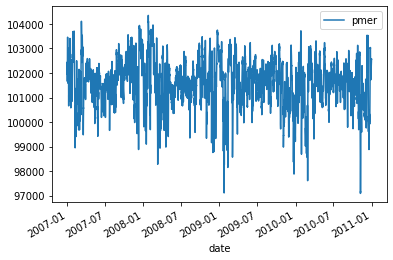

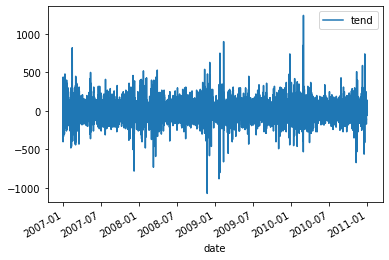

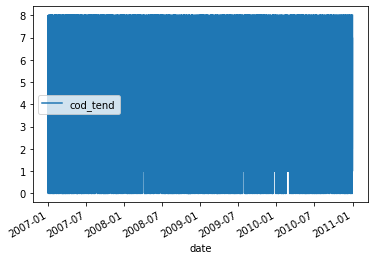

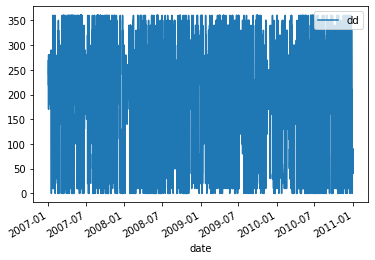

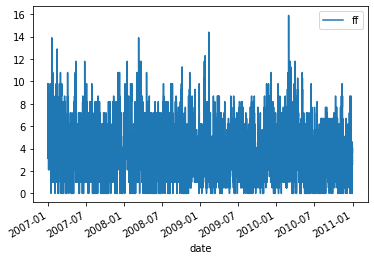

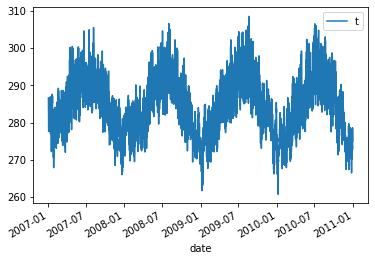

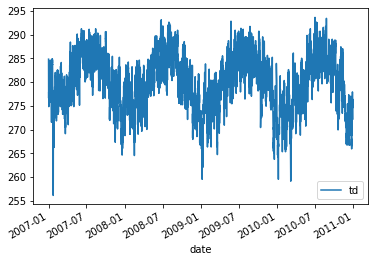

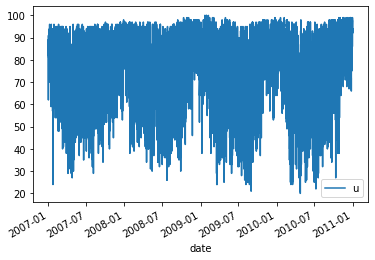

In [7]:
for name in all_weather.columns:
  all_weather[name].plot()
  plt.legend()
  plt.show()

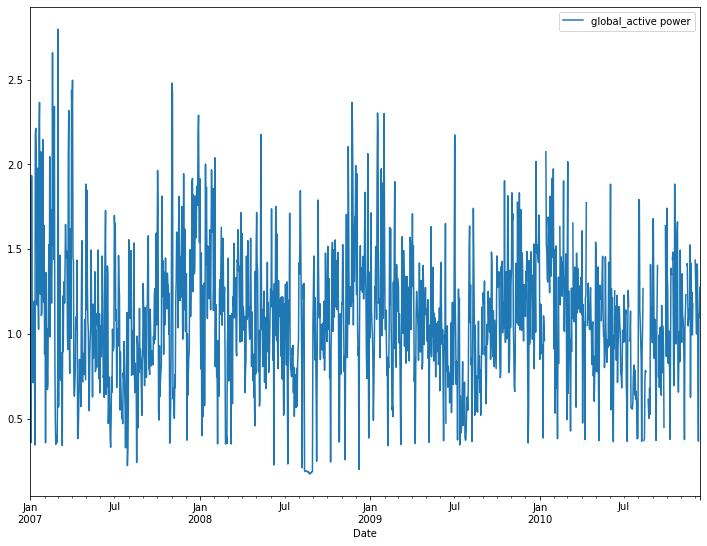

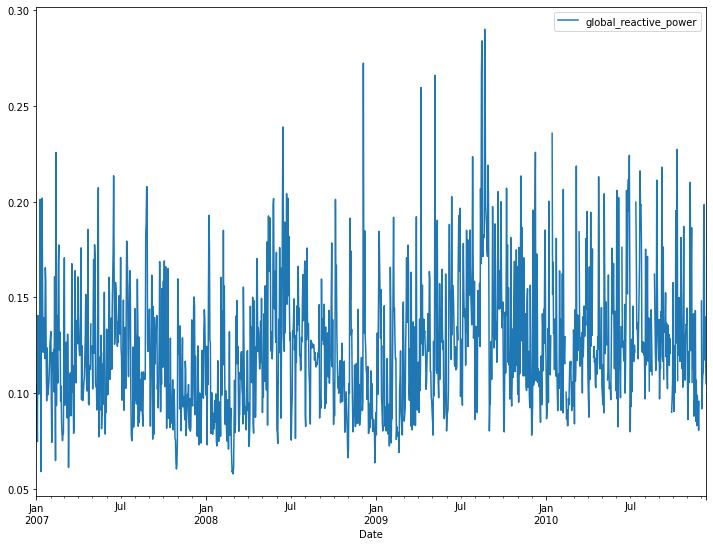

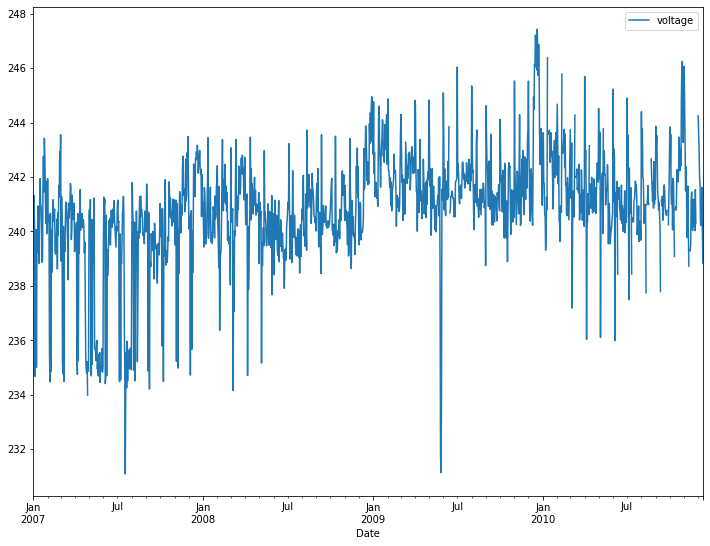

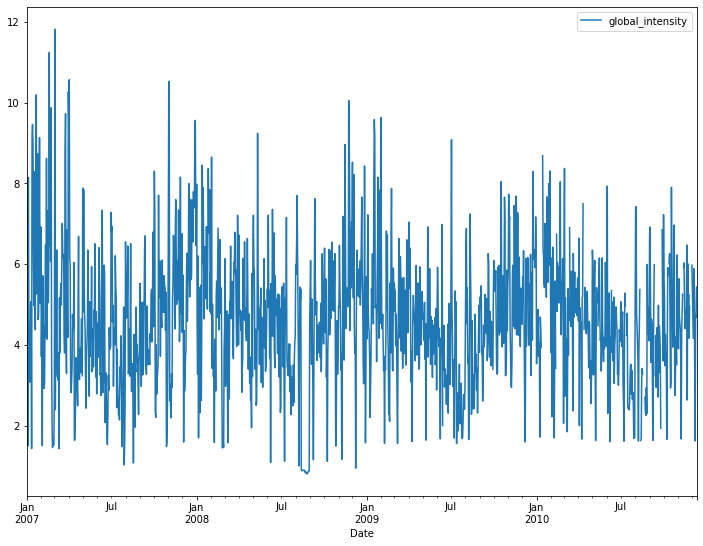

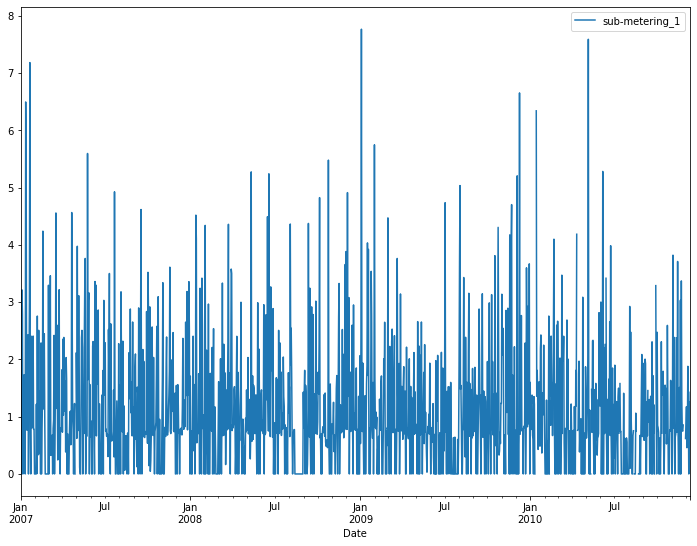

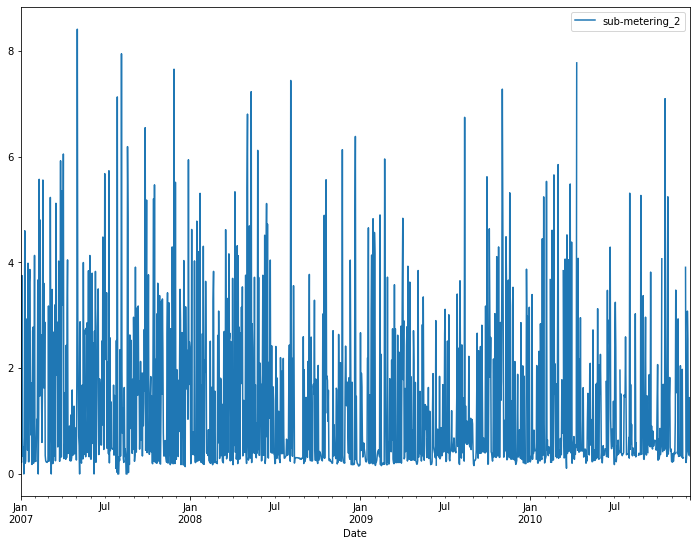

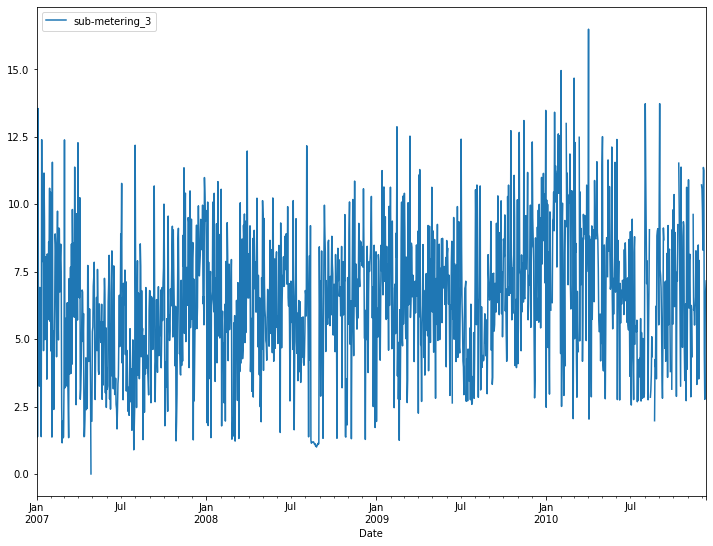

In [8]:
for c in ['global_active power', 'global_reactive_power', 'voltage' , 'global_intensity', 'sub-metering_1', 'sub-metering_2', 'sub-metering_3']:
  all_pow_cons[c].resample('D').mean().plot(figsize = (12, 9))
  plt.legend()
  plt.show()

### Traitement des valeurs manquantes

Dans notre cas, nous n'allons pas supprimer les valeurs manquantes. Nous allons plutôt faire un $Backfill$. En effet nous faisons ce choix car l'on pourrait supposer que d'une minute à l'autre (dans le cas des données de consommation de puissance) ou de 3h à l'autre (dans le cas des données météorologiques), la valeur en question n'a pas changé.

In [9]:
all_weather.isnull().sum()

pmer         7
tend        27
cod_tend    27
dd           3
ff           3
t            7
td           7
u            7
dtype: int64

In [10]:
all_weather.fillna(method ='bfill', inplace=True)

In [11]:

# Remplacement des valeurs manquantes
all_pow_cons.fillna(method ='bfill', inplace=True)
all_pow_cons.dtypes

global_active power      float64
global_reactive_power    float64
voltage                  float64
global_intensity         float64
sub-metering_1           float64
sub-metering_2           float64
sub-metering_3           float64
dtype: object

### Calcul de l'énergie consommée

In [12]:
exclusive_energie = all_pow_cons['global_active power'] * 1000/60 - all_pow_cons['sub-metering_1'] - all_pow_cons['sub-metering_2'] - all_pow_cons['sub-metering_3']
all_pow_cons['exclusive_energie']= exclusive_energie
#+ all_pow_cons[3].pow(2)).pow(0.5)
exclusive_energie.head(n=5)
#active_power['2009-01-01 09:00:00'].plot()


Date
2007-01-01 00:00:00    43.000000
2007-01-01 00:01:00    42.533333
2007-01-01 00:02:00    42.500000
2007-01-01 00:03:00    42.500000
2007-01-01 00:04:00    42.566667
dtype: float64

### Visualisation de l'énergie en journalier

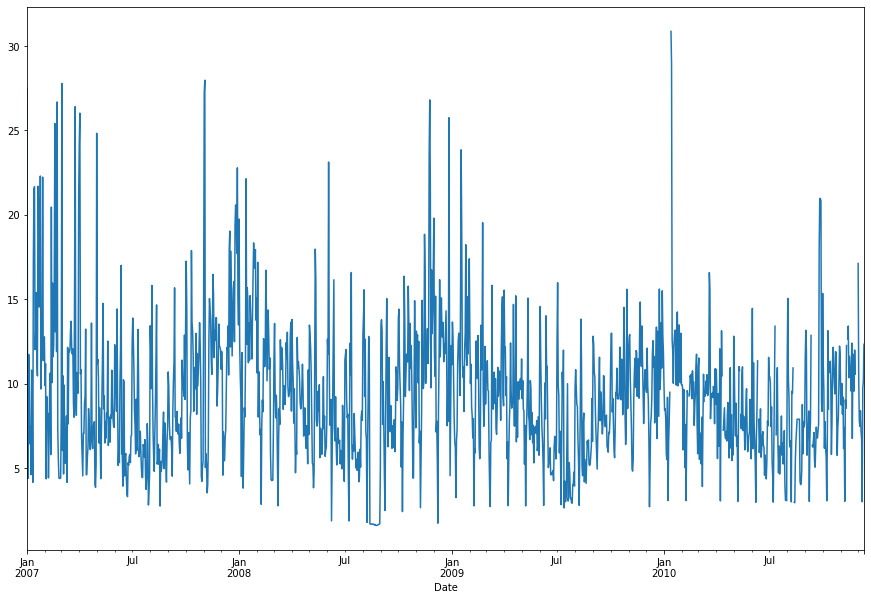

In [13]:
exclusive_energie.resample('D').mean().plot(figsize = (15, 10))

In [14]:
exclusive_energie = pd.DataFrame(exclusive_energie)
exclusive_energie

,0
Date,
2007-01-01 00:00:00,43.000000
2007-01-01 00:01:00,42.533333
2007-01-01 00:02:00,42.500000
2007-01-01 00:03:00,42.500000
2007-01-01 00:04:00,42.566667
...,...
2010-11-26 20:58:00,15.766667
2010-11-26 20:59:00,15.733333
2010-11-26 21:00:00,15.633333


## Extraction de cycle et tendance

Nous faisons cela dans le but de discuter de la structure de notre timeseries. Notre timeserie a-t-elle une tendance, un cycle?

In [15]:
all_weather.isna().sum()

pmer        0
tend        0
cod_tend    0
dd          0
ff          0
t           0
td          0
u           0
dtype: int64

In [16]:
exclusive_energie.index

DatetimeIndex(['2007-01-01 00:00:00', '2007-01-01 00:01:00',
               '2007-01-01 00:02:00', '2007-01-01 00:03:00',
               '2007-01-01 00:04:00', '2007-01-01 00:05:00',
               '2007-01-01 00:06:00', '2007-01-01 00:07:00',
               '2007-01-01 00:08:00', '2007-01-01 00:09:00',
               ...
               '2010-11-26 20:53:00', '2010-11-26 20:54:00',
               '2010-11-26 20:55:00', '2010-11-26 20:56:00',
               '2010-11-26 20:57:00', '2010-11-26 20:58:00',
               '2010-11-26 20:59:00', '2010-11-26 21:00:00',
               '2010-11-26 21:01:00', '2010-11-26 21:02:00'],
              dtype='datetime64[ns]', name='Date', length=2053263, freq=None)

In [17]:
t = all_weather.resample('D').mean()
t.isna().sum()

pmer        0
tend        0
cod_tend    0
dd          0
ff          0
t           0
td          0
u           0
dtype: int64

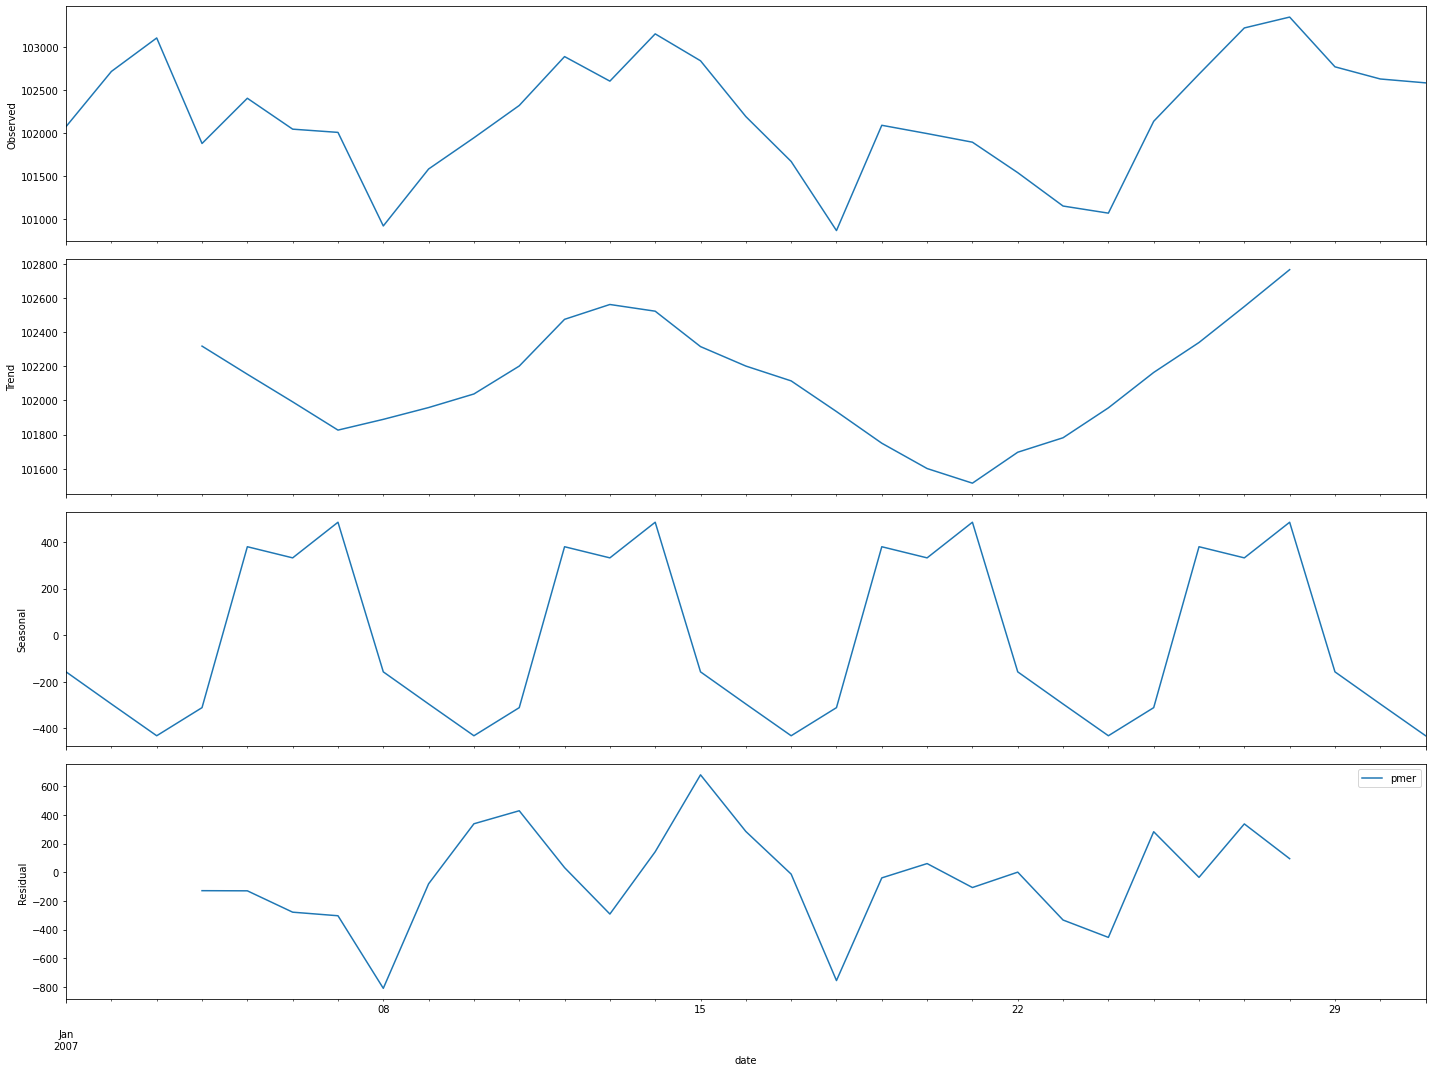

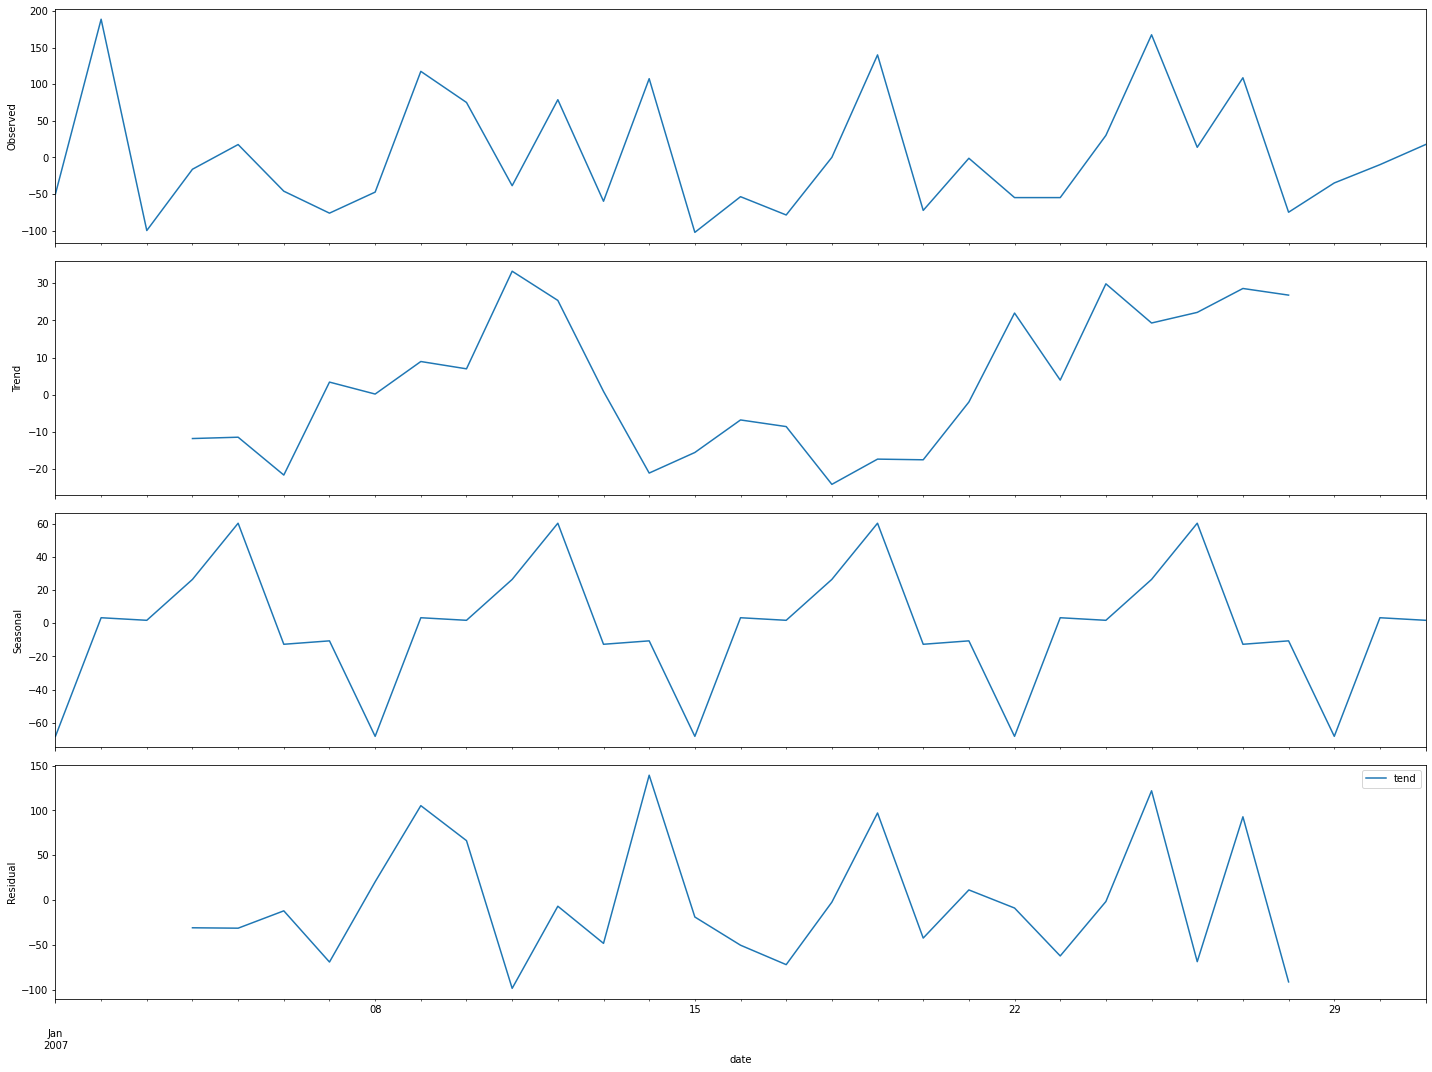

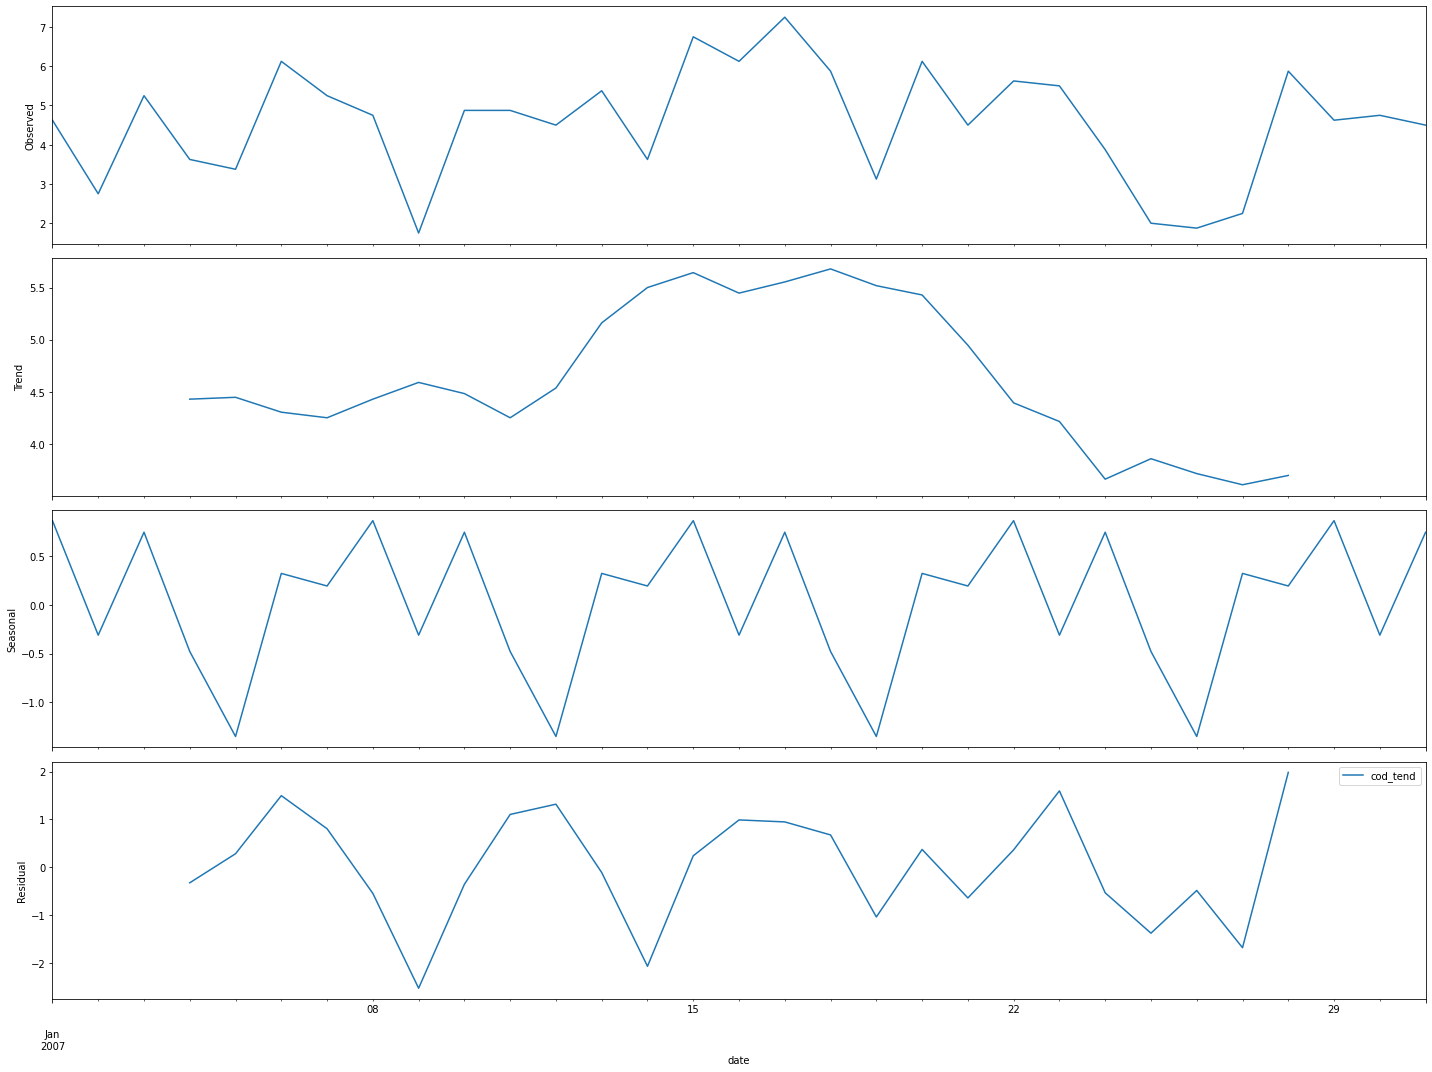

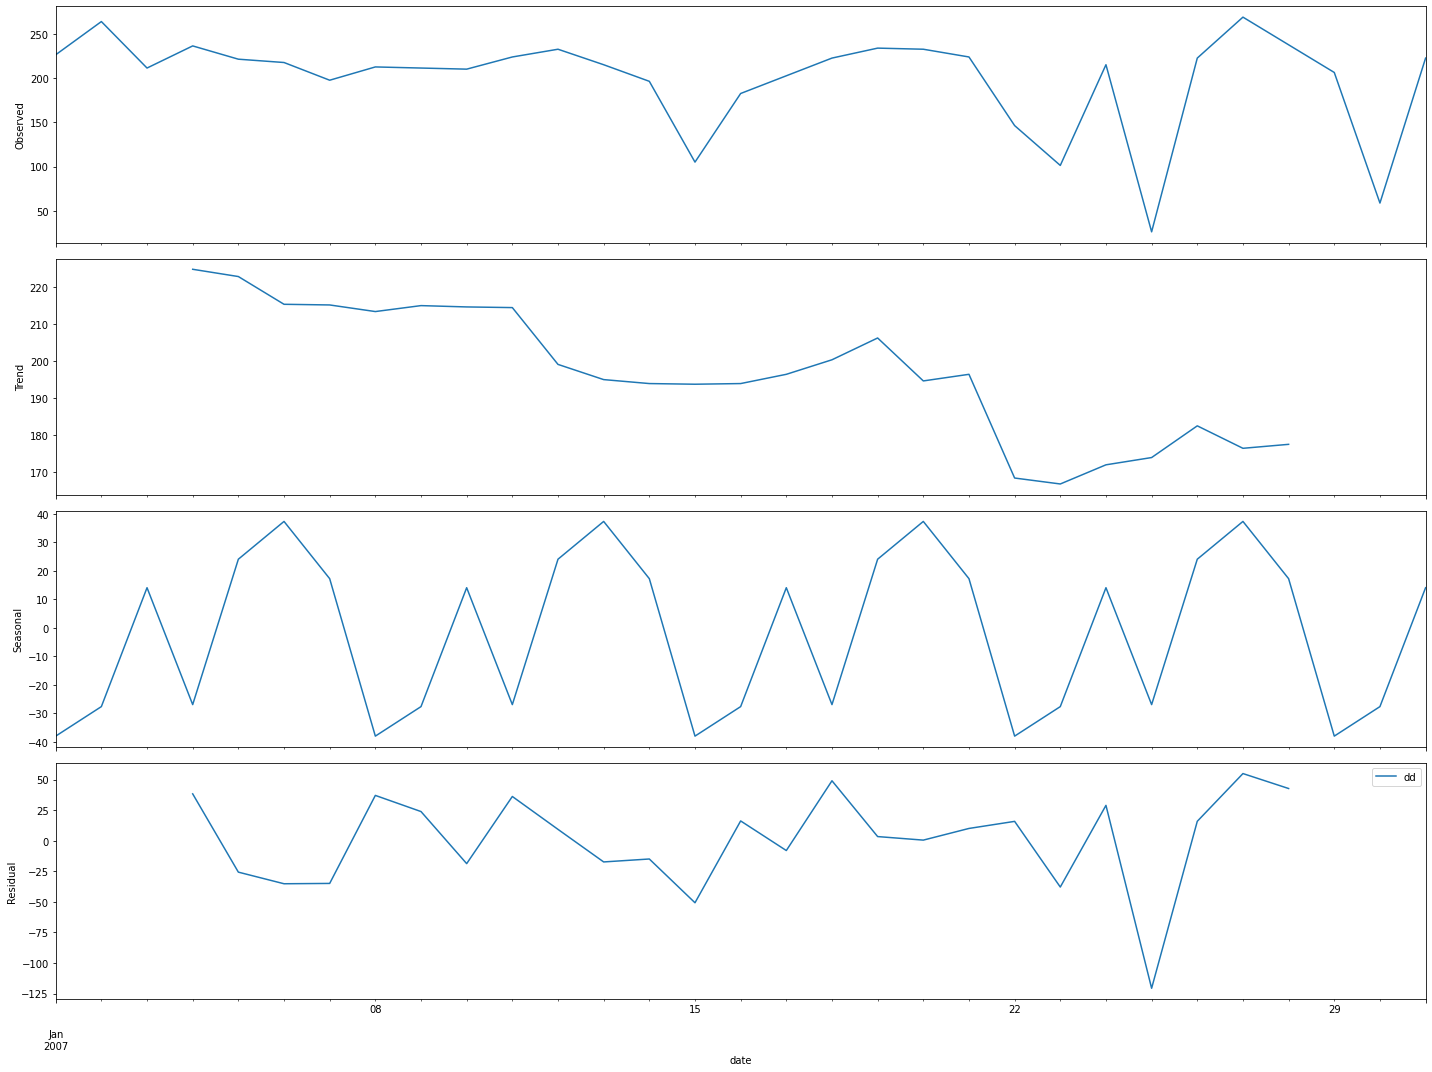

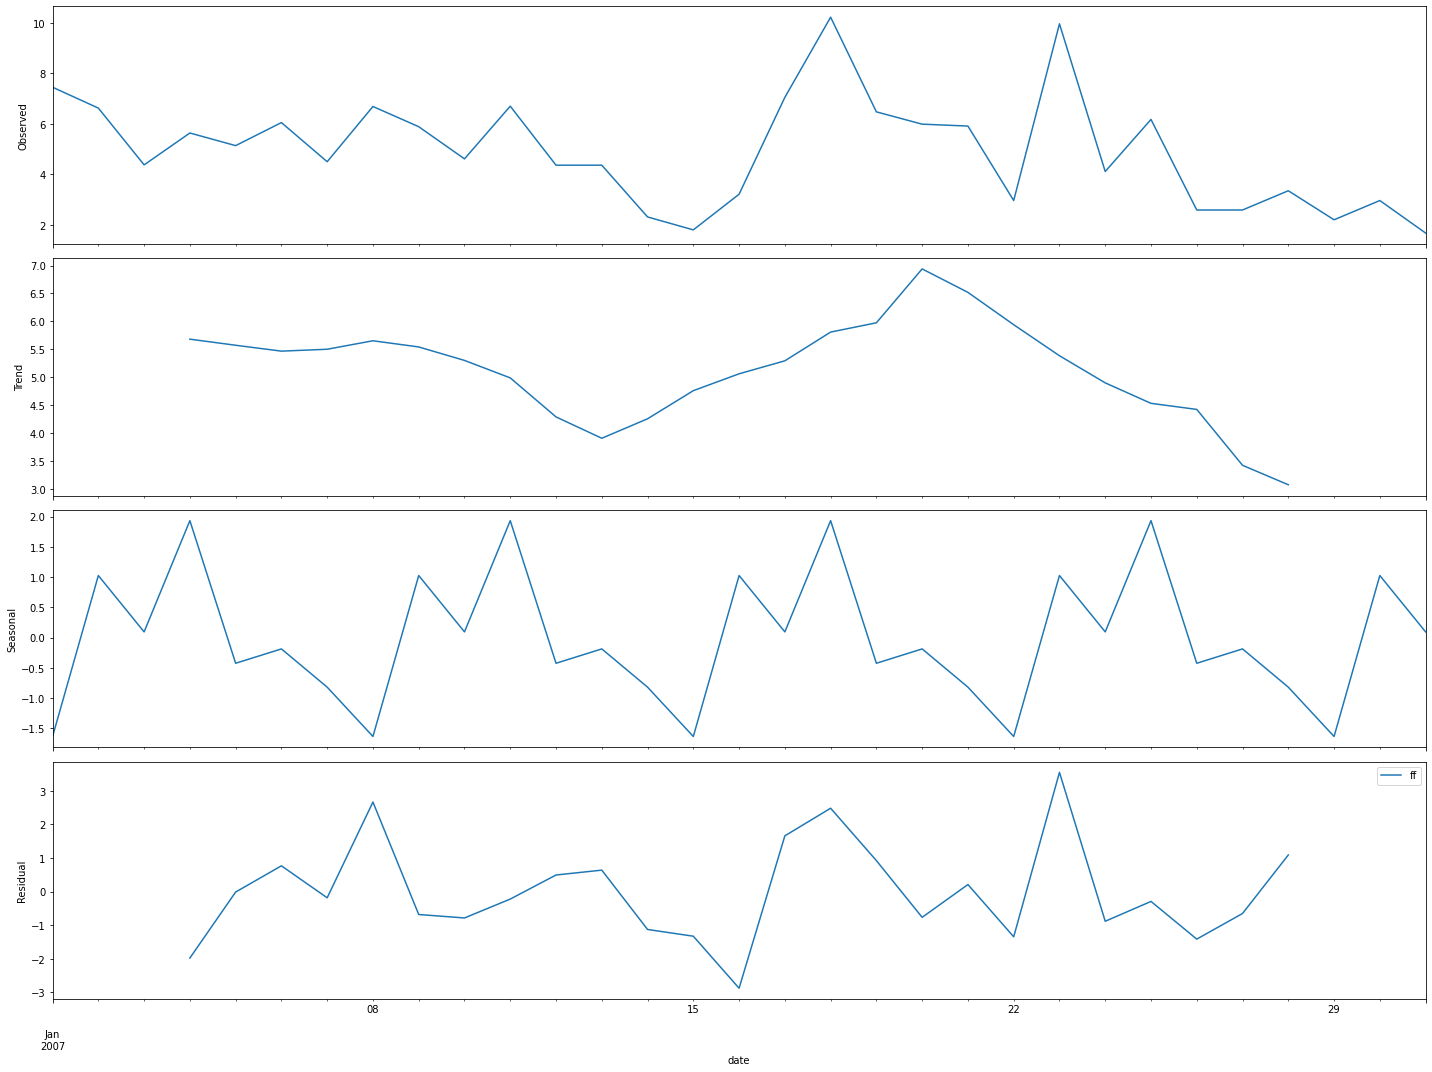

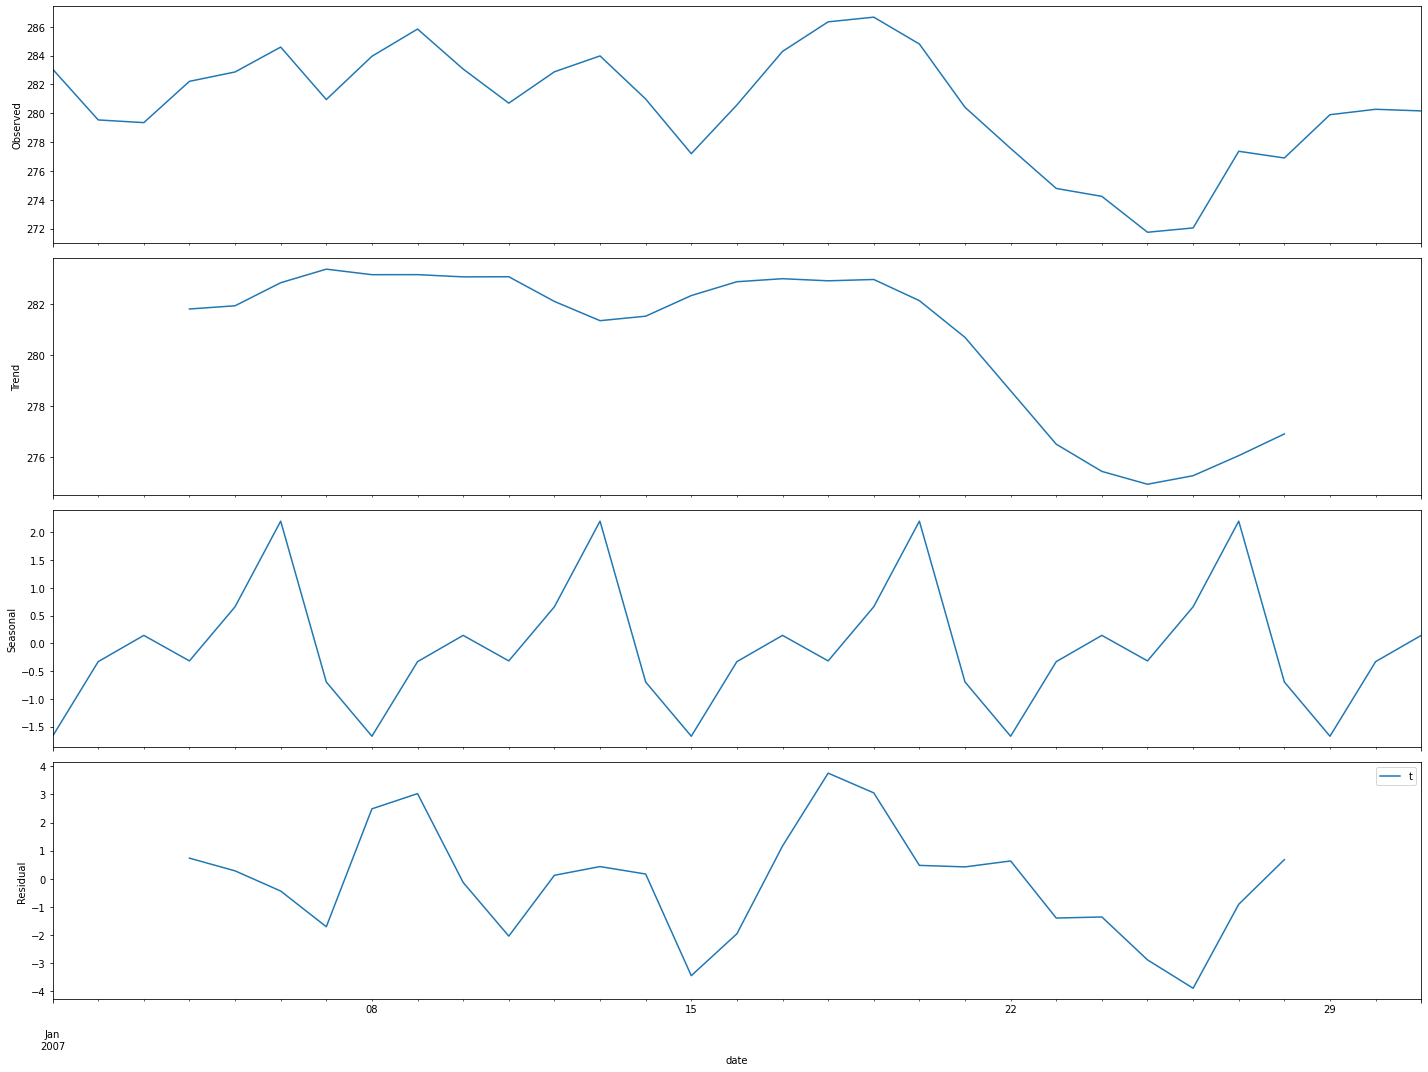

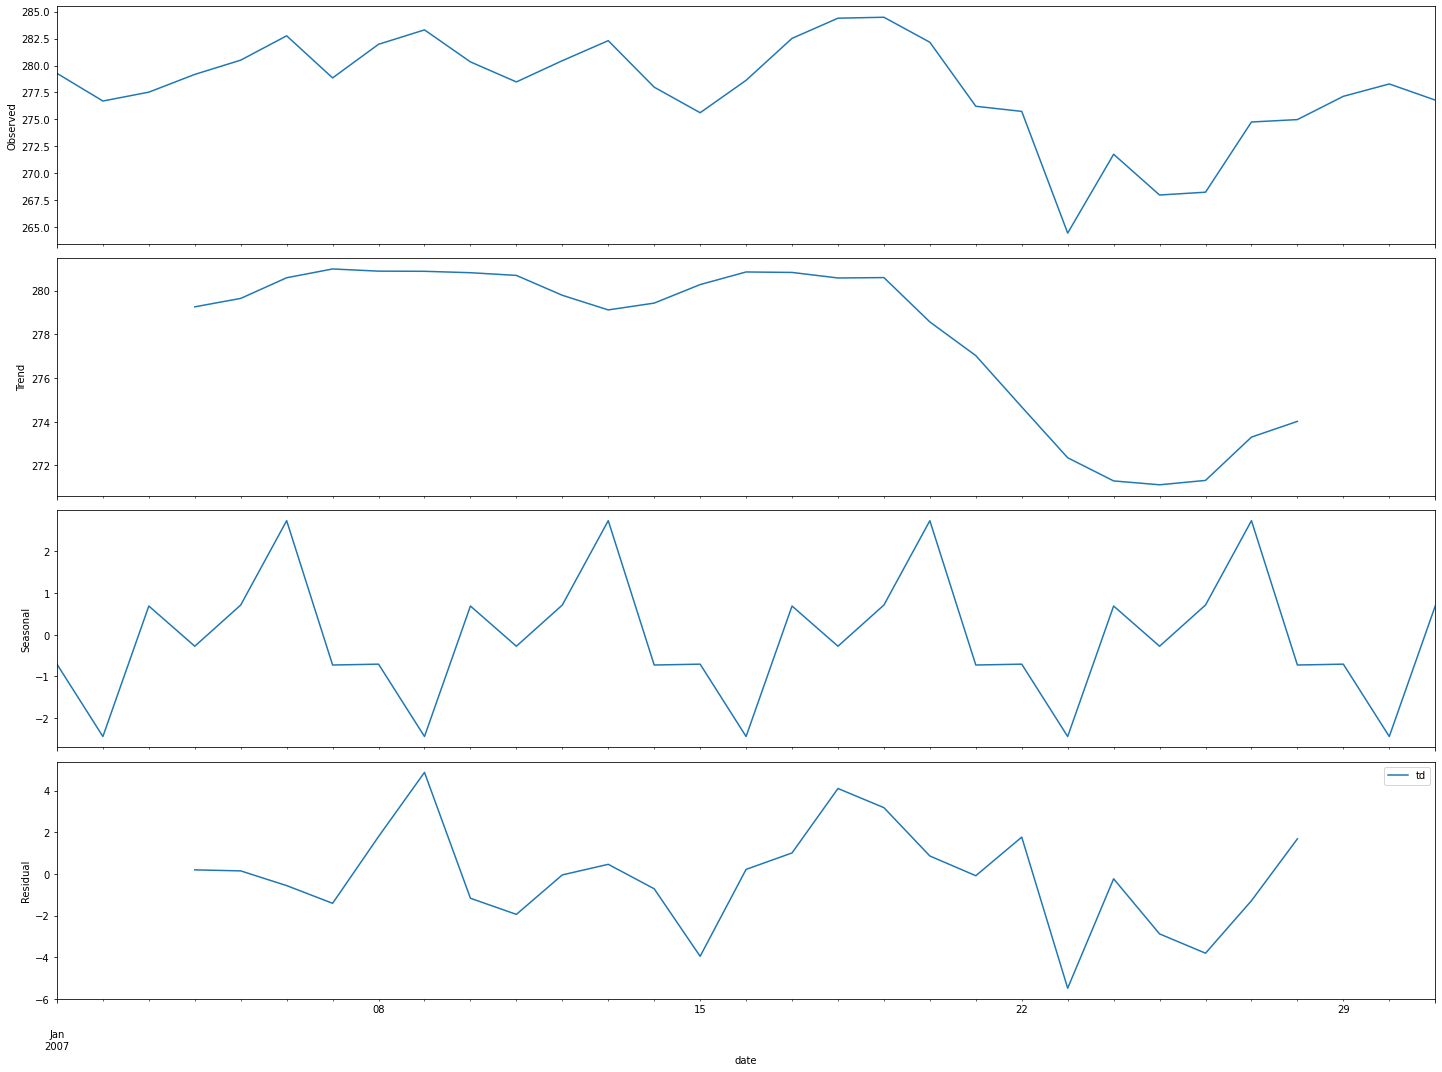

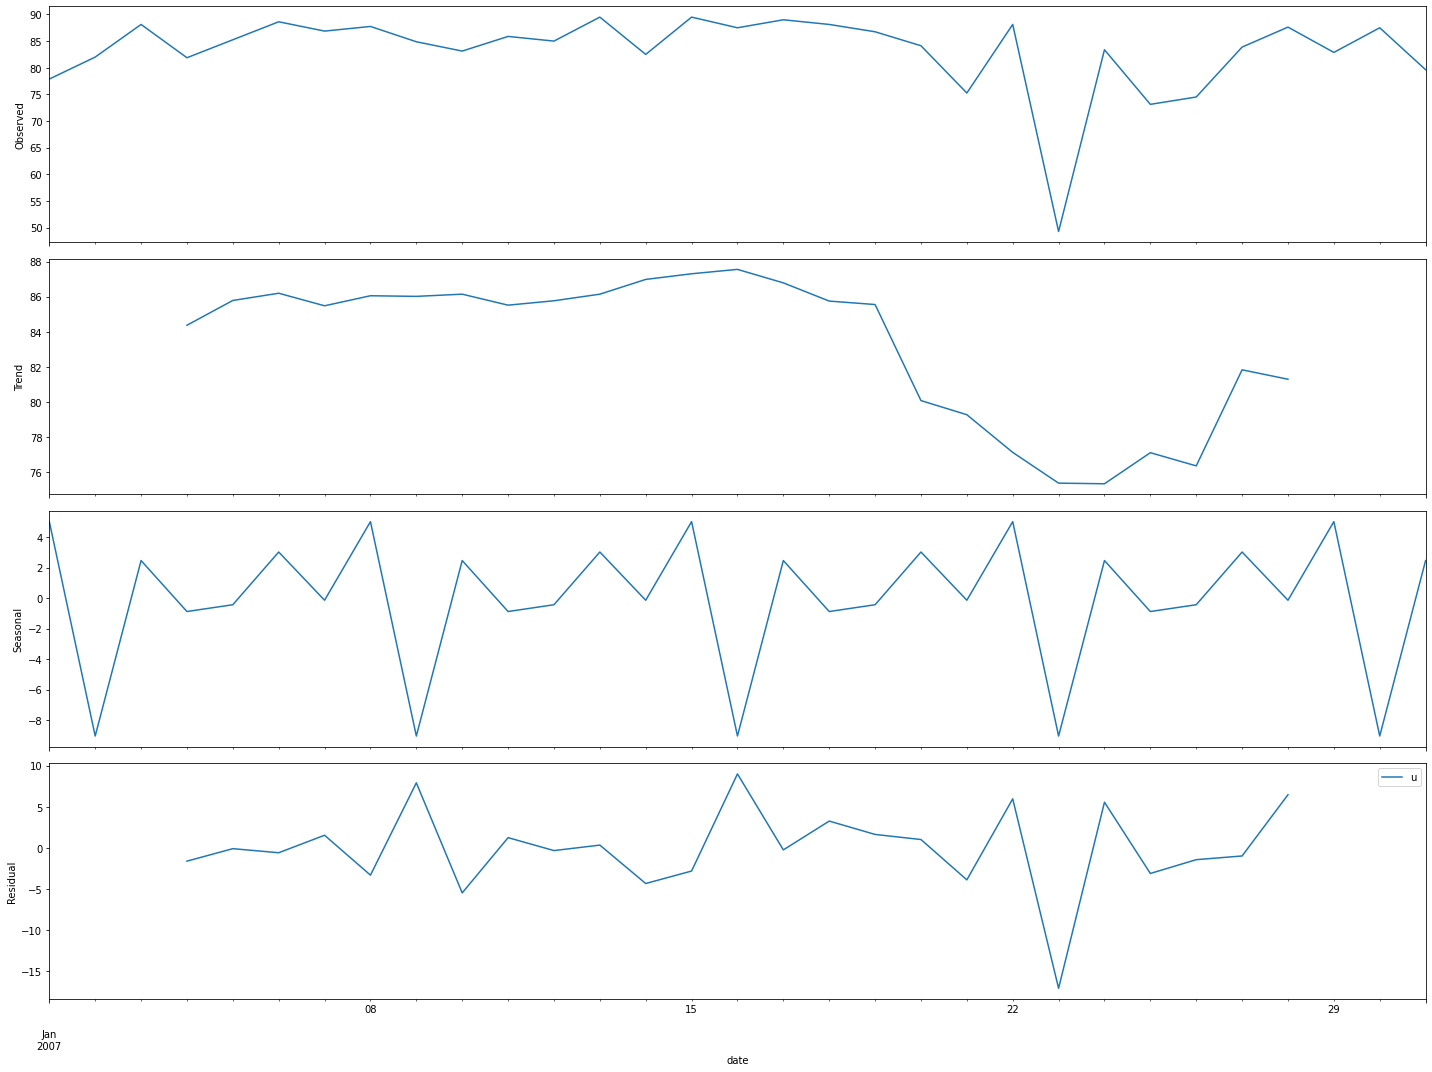

In [18]:
from pylab import rcParams

for g in t.columns : 
  rcParams['figure.figsize'] = 20, 15
  decomposition = sm.tsa.seasonal_decompose(t[g]['2007-01'])
  fig = decomposition.plot()
  plt.legend()
  plt.show()

En observant ces données on se rend compte d'une similitude entre elles d'une année à l'autre, notamment en ce qui concerne la température. En diminuant l'échelle du tracé, on remarque également que ces variables présentent en moyennes 04 cycles en un mois, soit des cycles de 7 à 8 jours.

In [19]:
 ts = pd.to_dataframe(exclusive_energie.resample('D').mean())
 all_weather.dtypes

AttributeError: ignored

In [20]:
ts.isna().sum()
ts.dropna(inplace=True)

rcParams['figure.figsize'] = 20, 15
decompositions = sm.tsa.seasonal_decompose(ts)
fig = decompositions.plot()
plt.show()

NameError: ignored

## Préprocessing des données

Dans nos données, nous trouvons des valeurs que l'on peux qualifiers extrêmes. Afin d'en tenir compte et de réduire leur effet, nous utilisons la fonction $Z-score.$ On corrige également cet anomalie en faisant un $backfill.$ L'une des raisons de ce choix est données plus haut et la seconde est liée au fait qu'en supprimant les outliers, on obtiendrai des vecteurs jours de dimension inégales, ce qui nuirait à l'utilisation de $KMeans$ qui nécessite des vecteurs de même taille.

In [23]:
for c in all_pow_cons.columns:
  all_pow_cons[c +'_score'] = stats.zscore(all_pow_cons[c])
  
all_pow_cons

,global_active power,global_reactive_power,voltage,global_intensity,sub-metering_1,sub-metering_2,sub-metering_3,exclusive_energie,global_active power_score,global_reactive_power_score,voltage_score,global_intensity_score,sub-metering_1_score,sub-metering_2_score,sub-metering_3_score,exclusive_energie_score,global_active power_score_score,global_reactive_power_score_score,voltage_score_score,global_intensity_score_score,sub-metering_1_score_score,sub-metering_2_score_score,sub-metering_3_score_score,exclusive_energie_score_score
Date,,,,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN
2007-01-01 00:04:00,2.554,0.100,241.98,10.4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 20:58:00,0.946,0.000,240.43,4.0,0.0,0.0,0.0,15.766667,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN
2010-11-26 20:59:00,0.944,0.000,240.00,4.0,0.0,0.0,0.0,15.733333,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN
2010-11-26 21:00:00,0.938,0.000,239.82,3.8,0.0,0.0,0.0,15.633333,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.764012,NaN


In [24]:
# Let's assume that we're dealing with a normal distribution 
for c in ['global_active power', 'global_reactive_power', 'voltage' , 'global_intensity', 'sub-metering_1', 'sub-metering_2', 'sub-metering_3', 'exclusive_energie']:
  all_pow_cons[c]=all_pow_cons[c][all_pow_cons[c+'_score']< 3]
all_pow_cons.isna().sum()
#z_score0 = (power_consumption - power_consumption.mean())/((n/(n-1))*power_consumption.std())
#z_score0

global_active power                  2053263
global_reactive_power                2053263
voltage                              2053263
global_intensity                     2053263
sub-metering_1                       2053263
sub-metering_2                       2053263
sub-metering_3                             0
exclusive_energie                    2053263
global_active power_score            2053263
global_reactive_power_score          2053263
voltage_score                        2053263
global_intensity_score               2053263
sub-metering_1_score                 2053263
sub-metering_2_score                 2053263
sub-metering_3_score                       0
exclusive_energie_score              2053263
global_active power_score_score      2053263
global_reactive_power_score_score    2053263
voltage_score_score                  2053263
global_intensity_score_score         2053263
sub-metering_1_score_score           2053263
sub-metering_2_score_score           2053263
sub-meteri

In [25]:
# pourcentage de valeurs dont le z_score est > 3
all_pow_cons.fillna(method ='bfill', inplace=True)
all_pow_cons.isna().sum()

global_active power                  2053263
global_reactive_power                2053263
voltage                              2053263
global_intensity                     2053263
sub-metering_1                       2053263
sub-metering_2                       2053263
sub-metering_3                             0
exclusive_energie                    2053263
global_active power_score            2053263
global_reactive_power_score          2053263
voltage_score                        2053263
global_intensity_score               2053263
sub-metering_1_score                 2053263
sub-metering_2_score                 2053263
sub-metering_3_score                       0
exclusive_energie_score              2053263
global_active power_score_score      2053263
global_reactive_power_score_score    2053263
voltage_score_score                  2053263
global_intensity_score_score         2053263
sub-metering_1_score_score           2053263
sub-metering_2_score_score           2053263
sub-meteri

In [26]:
all_pow_cons['exclusive_energie'+'_score'] = stats.zscore(all_pow_cons['exclusive_energie'])

In [27]:
all_pow_cons['exclusive_energie_score'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: exclusive_energie_score, dtype: float64

<function matplotlib.pyplot.show>

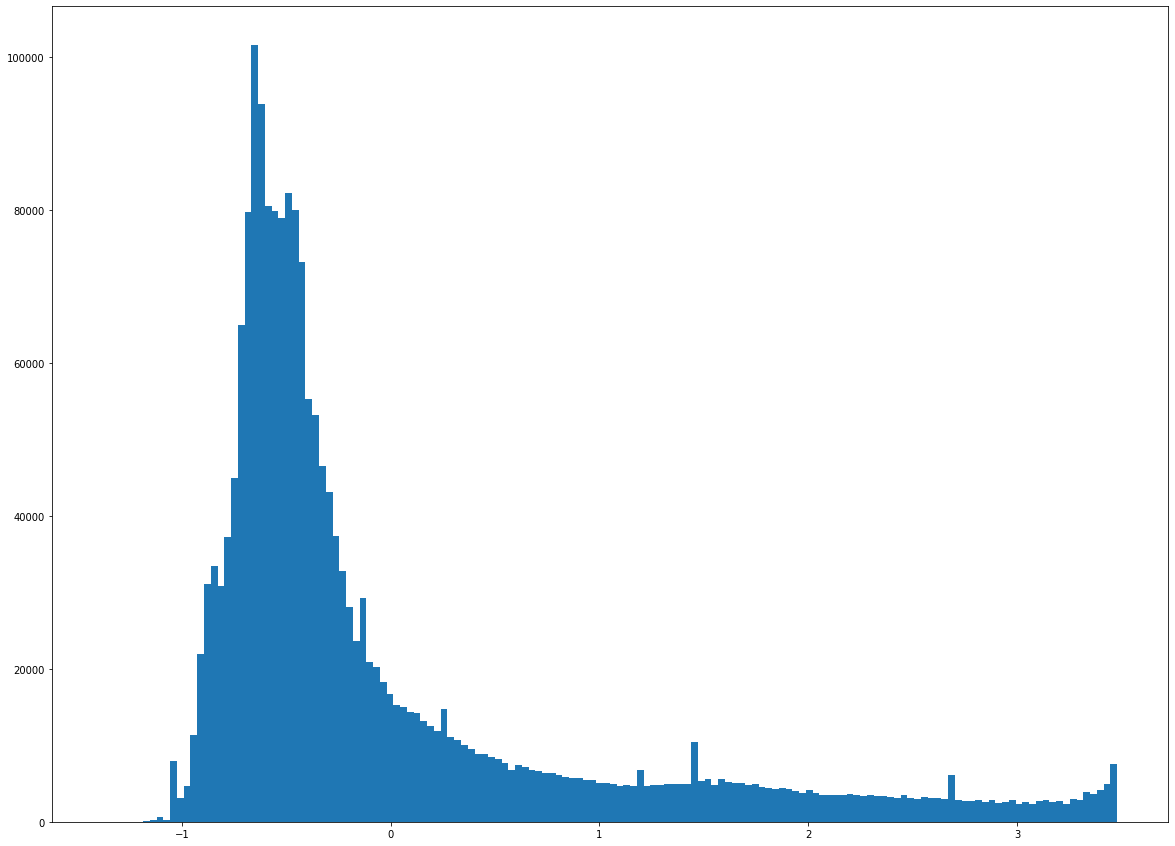

In [ ]:
plt.hist(all_pow_cons['exclusive_energie_score'], bins = 150)
plt.show

In [ ]:
all_weather.describe()

,pmer,tend,cod_tend,dd,ff,t,td,u
count,11656.000000,11656.000000,11656.000000,11656.000000,11656.000000,11656.000000,11656.000000,11656.000000
mean,101616.780199,0.152711,4.353723,186.836822,3.700618,284.658948,280.042244,75.869681
std,952.456404,127.370371,2.715774,105.772748,2.090119,7.289673,5.687154,17.102289
min,97090.000000,-1070.000000,0.000000,0.000000,0.000000,260.750000,256.150000,20.000000
25%,101070.000000,-70.000000,2.000000,80.000000,2.100000,279.450000,276.150000,64.000000
50%,101680.000000,0.000000,5.000000,210.000000,3.100000,284.650000,280.550000,80.000000
75%,102220.000000,70.000000,7.000000,270.000000,5.100000,289.950000,284.350000,90.000000
max,104350.000000,1240.000000,8.000000,360.000000,15.900000,308.550000,293.650000,100.000000


# 2- Détection de saisonalité dans la consommation d'énergie

Nous allons pour cela appliquer $K-means$.

In [ ]:
X_var = np.array(all_pow_cons['exclusive_energie'].resample('D')) 
X_var
X = X_var[2,1].values.reshape(1,X_var[2,1].values.shape[0])
L = []

for i in range(1, X_var.shape[0]):
  if(X_var[i,1].values.shape[0]==X_var[2,1].values.shape[0]):
    X = np.concatenate((X, X_var[i,1].values.reshape(1,X_var[2,1].values.shape[0])), axis=0)
    L.append(X_var[i,1].values.shape[0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


<function matplotlib.pyplot.show>

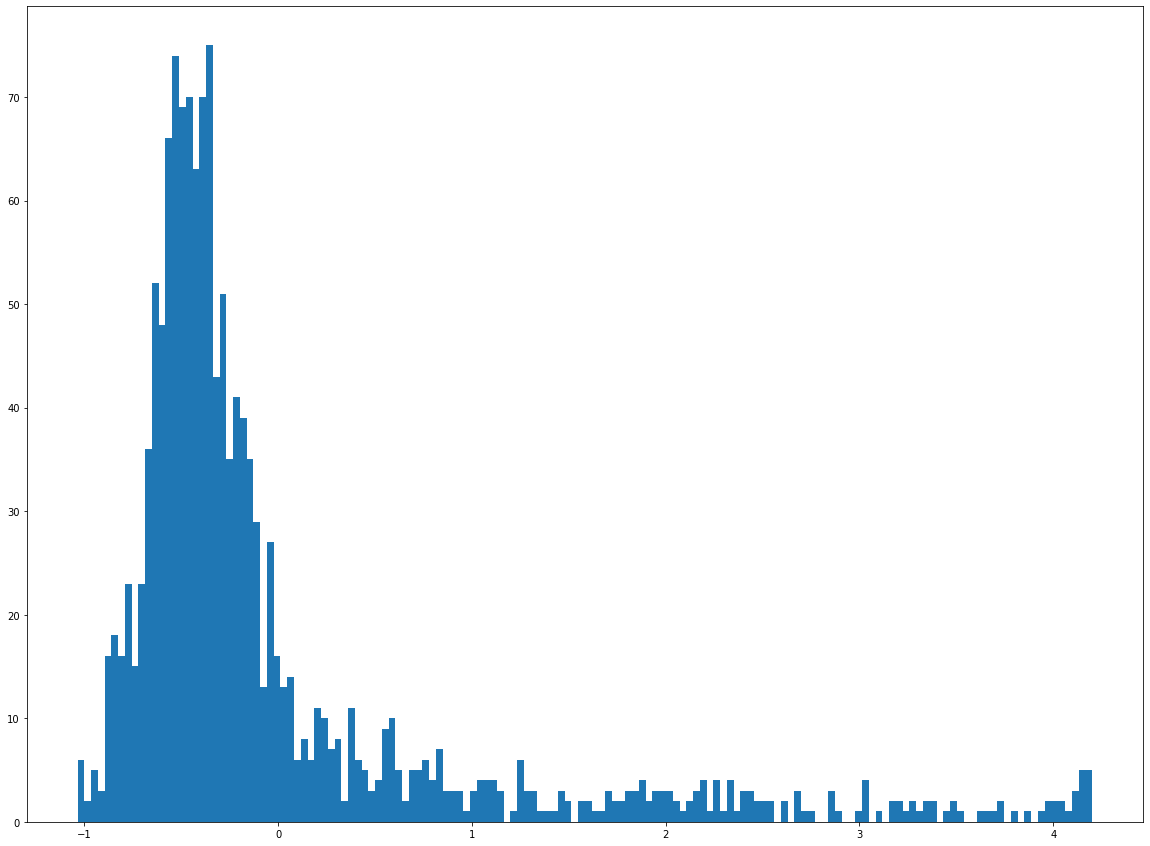

In [ ]:
#active_power.groupby(pd.Grouper(freq='d'))
mms = StandardScaler()
mms.fit(X)
data_transformed = mms.transform(X)
plt.hist(data_transformed[:,0], bins=150)
plt.show

In [ ]:
Sum_of_squared_distances = []
sil_score = []

for k in range(2,15):
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    score = silhouette_score(X, km.labels_ , metric='euclidean')
    Sum_of_squared_distances.append(score)

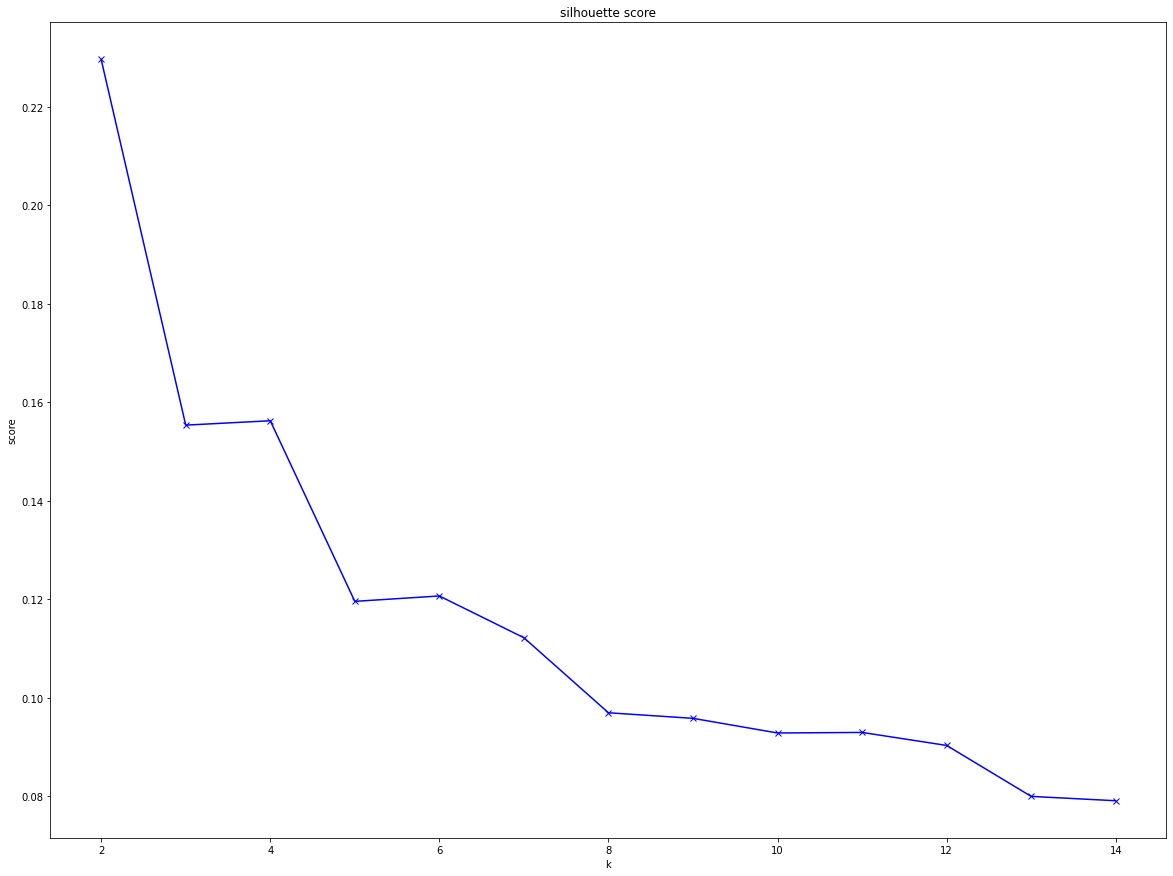

In [ ]:
plt.plot(range(2,15), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('score')
plt.title('silhouette score')
plt.show()

In [ ]:
Sum_of_squared_distances_2 = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances_2.append(km.inertia_)

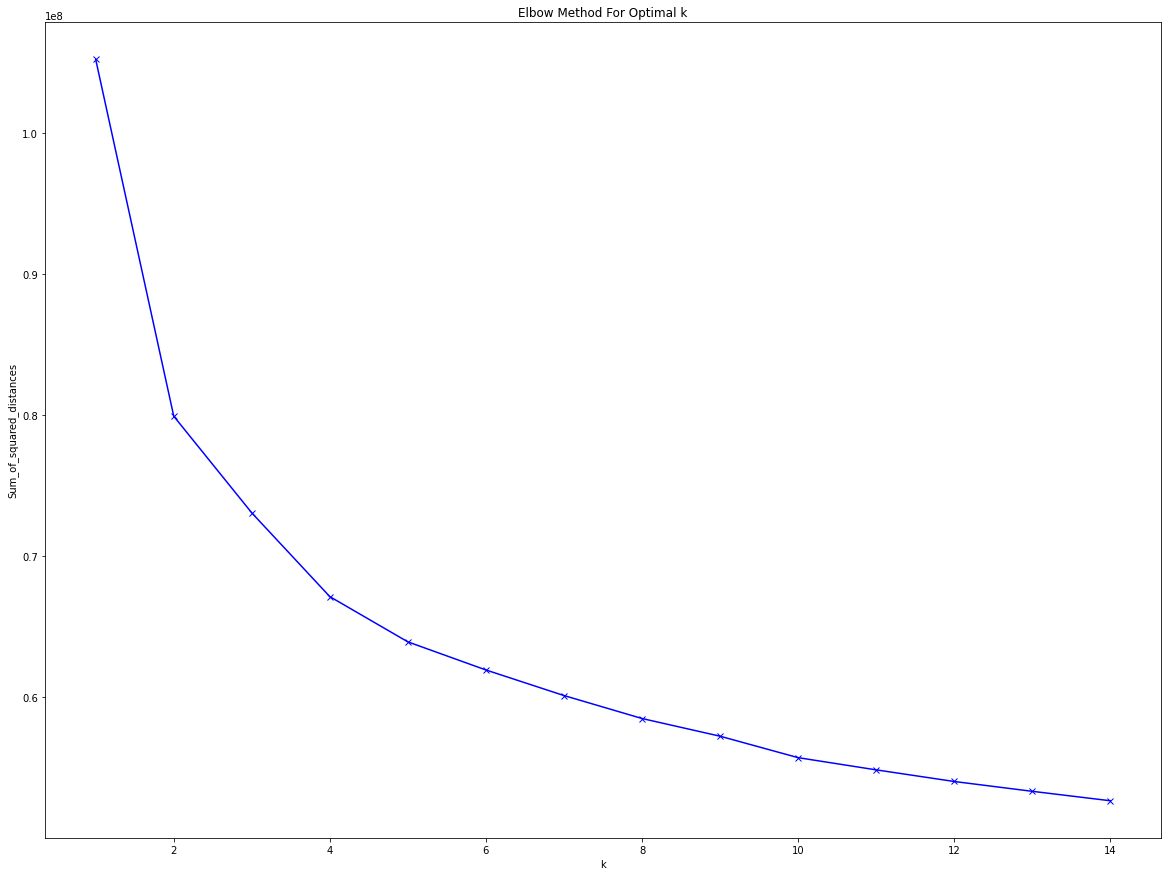

In [ ]:
plt.plot(K, Sum_of_squared_distances_2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

Les deux graphiques précédents, montrents qu'il y'a des périodes qui peuvent être regroupées ensembles. La silhouette score confirme que l'année pourrait être divisée en deux parties : 'season1' et 'season2'. On peut attribuer cette distinction au fait qu'on puisse regrouper les saisons en deux : les chaudes (prinptemps et été) et froides (automne et hiver); Selon la saison où l'on se trouve, les habitudes de consommations diffèrent (chauffage, air-conditioning, etc).

# 3- Distribution of Hourly Consumption

étant donné que nous afficherons la consommation horaire en fonction de notre clutering, nous ajoutons à notre data frame une colonne corespondant au labels obtenu par notre clustering   

In [ ]:
#affichage du nombre de jour dans chaque cluster
km1 = KMeans(n_clusters=2)
km1 = km1.fit(X)
label = km1.labels_
j=0
k=0
for i in range (X.shape[0]):
  if (label[i]==1):
    j+=1
  if (label[i]==0):
    k+=1
j , k 


(640, 785)

In [ ]:
#construction du vecteur colonne contenant les labels pour chacune des minutes
labels_s =np.zeros(2053263)
for i in range (len(label)):
  for j in range (1440):
    labels_s[i*1440+j]=label[i]


In [ ]:
all_pow_cons['labels'] = labels_s
all_pow_cons.head(n=4)

,global_active power,global_reactive_power,voltage,global_intensity,sub-metering_1,sub-metering_2,sub-metering_3,exclusive_energie,global_active power_score,global_reactive_power_score,voltage_score,global_intensity_score,sub-metering_1_score,sub-metering_2_score,sub-metering_3_score,exclusive_energie_score,labels
Date,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2.580,0.136,241.97,10.6,0.0,0.0,0.0,37.0,1.427113,0.107571,0.355455,1.362865,-0.181091,-0.222666,-0.764012,3.427097,0.0
2007-01-01 00:01:00,2.552,0.100,241.75,10.4,0.0,0.0,0.0,37.0,1.400371,-0.212235,0.287611,1.317418,-0.181091,-0.222666,-0.764012,3.427097,0.0
2007-01-01 00:02:00,2.550,0.100,241.64,10.4,0.0,0.0,0.0,37.0,1.398461,-0.212235,0.253689,1.317418,-0.181091,-0.222666,-0.764012,3.427097,0.0
2007-01-01 00:03:00,2.550,0.100,241.71,10.4,0.0,0.0,0.0,37.0,1.398461,-0.212235,0.275275,1.317418,-0.181091,-0.222666,-0.764012,3.427097,0.0


In [ ]:
#label = kmeans.labels_
cluster_1 = X[label == 1, :]
cluster_2 = X[label == 0, :]

In [ ]:
#regroupement des données de notre data set par heure de la journée
Y_var = np.array(all_pow_cons['exclusive_energie'].groupby(all_pow_cons['exclusive_energie'].index.hour))
Y_var

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([[0,
        Date
2007-01-01 00:00:00    37.000000
2007-01-01 00:01:00    37.000000
2007-01-01 00:02:00    37.000000
2007-01-01 00:03:00    37.000000
2007-01-01 00:04:00    37.000000
                         ...    
2010-11-26 00:55:00     3.633333
2010-11-26 00:56:00     3.633333
2010-11-26 00:57:00     3.666667
2010-11-26 00:58:00     3.633333
2010-11-26 00:59:00     3.600000
Name: exclusive_energie, Length: 85560, dtype: float64],
       [1,
        Date
2007-01-01 01:00:00    37.000000
2007-01-01 01:01:00    37.000000
2007-01-01 01:02:00    37.000000
2007-01-01 01:03:00    37.000000
2007-01-01 01:04:00    37.000000
                         ...    
2010-11-26 01:55:00     3.600000
2010-11-26 01:56:00     3.600000
2010-11-26 01:57:00     3.633333
2010-11-26 01:58:00     3.633333
2010-11-26 01:59:00     3.633333
Name: exclusive_energie, Length: 85560, dtype: float64],
       [2,
        Date
2007-01-01 02:00:00    37.000000
2007-01-01 02:01:00    37.000000
2007-01-01 02:02:00   

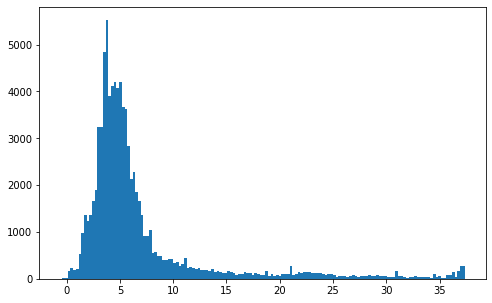

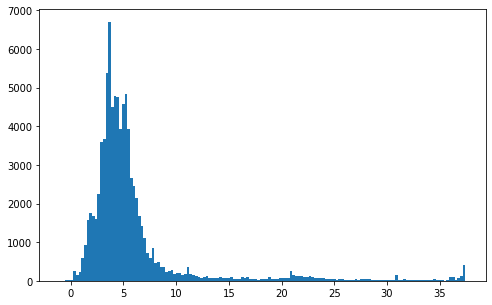

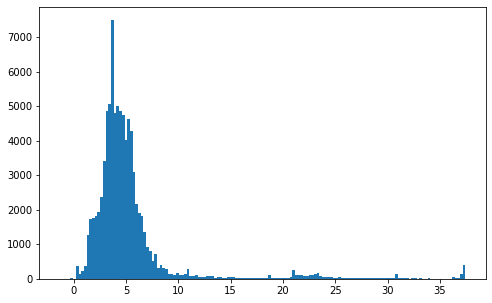

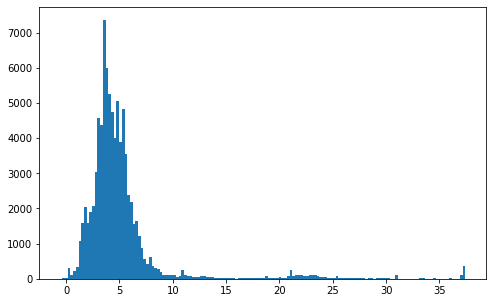

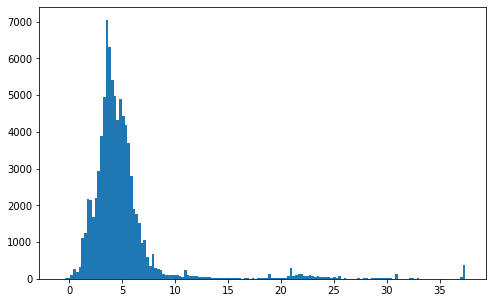

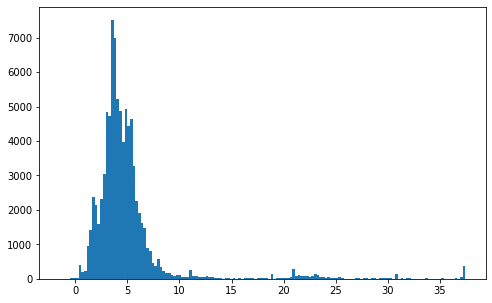

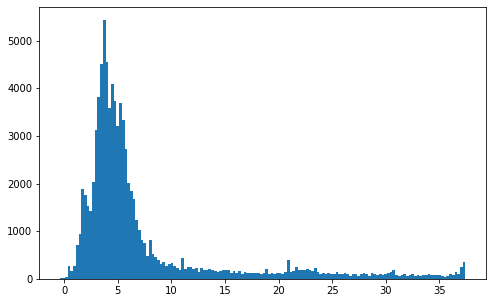

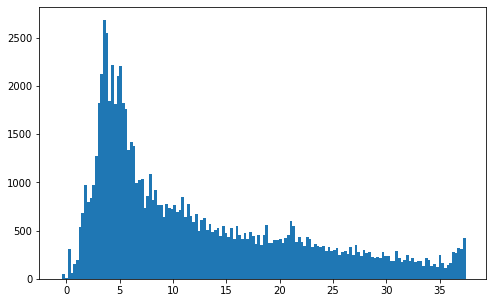

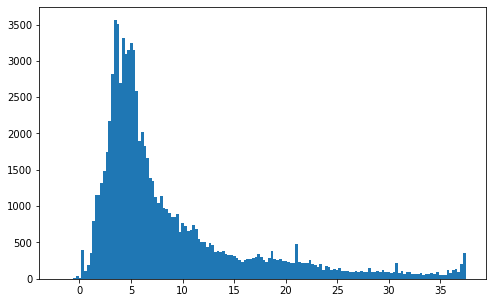

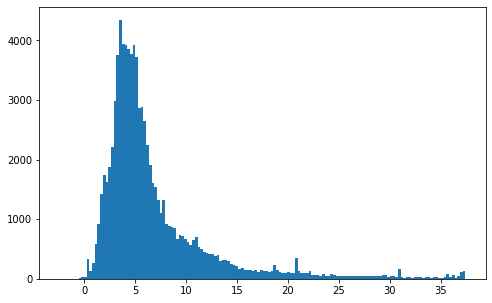

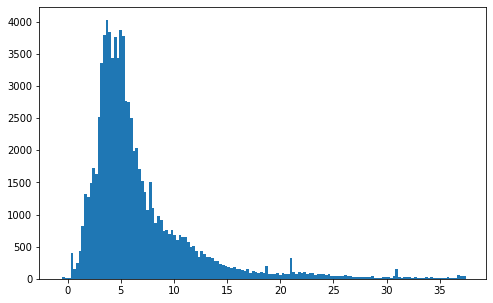

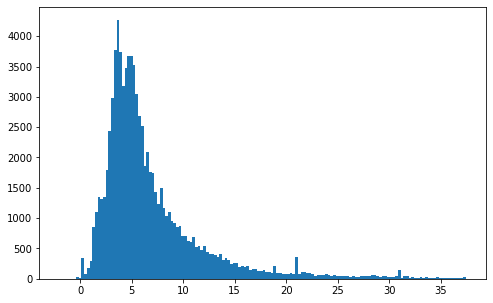

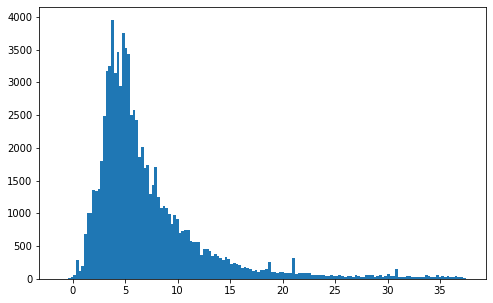

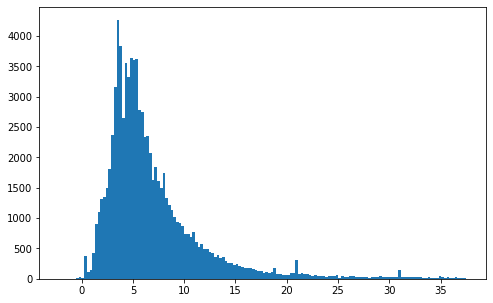

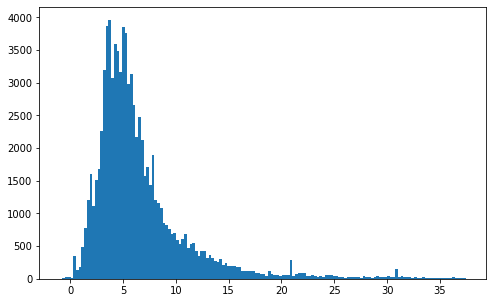

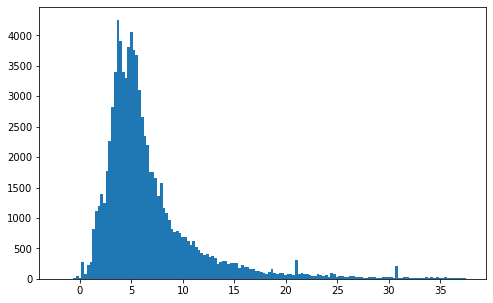

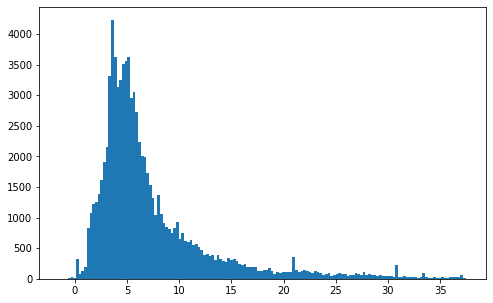

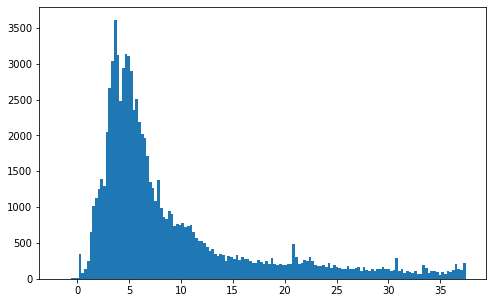

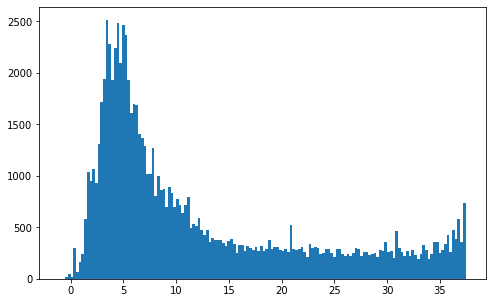

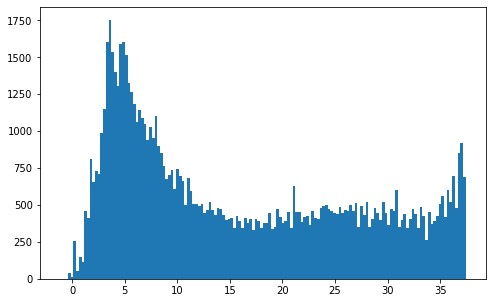

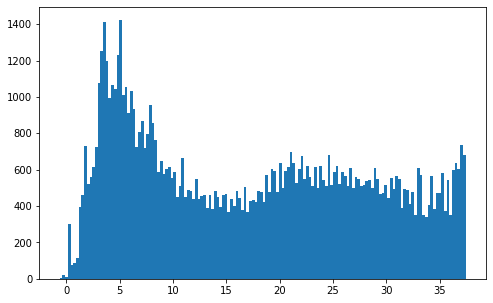

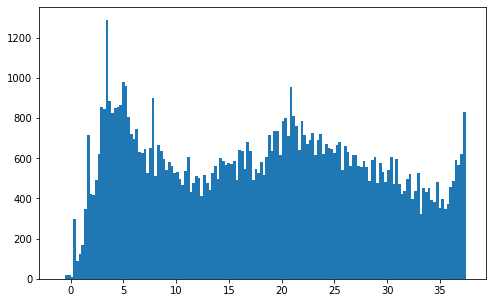

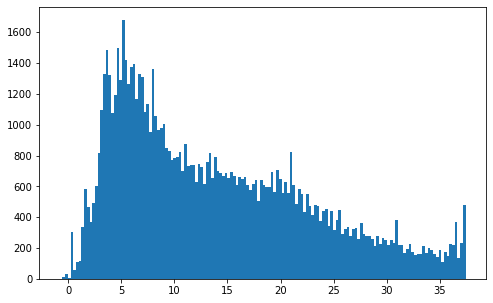

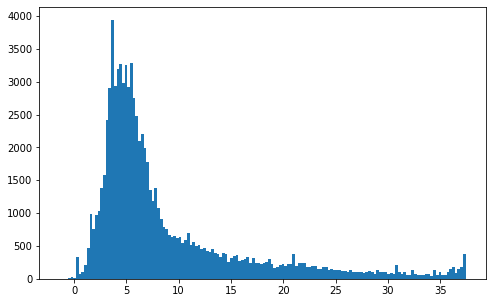

In [ ]:
#affichage de la forme de la distribution pour chaque heure la journée
for i in range (24):
  plt.figure(figsize=(8,5))
 # plt.subplot(((i%4)+1)*100+ ((i%6)+1)*10+ i%6+1)
  plt.hist(Y_var[i,1].values, bins = 150)
  plt.show()



In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")

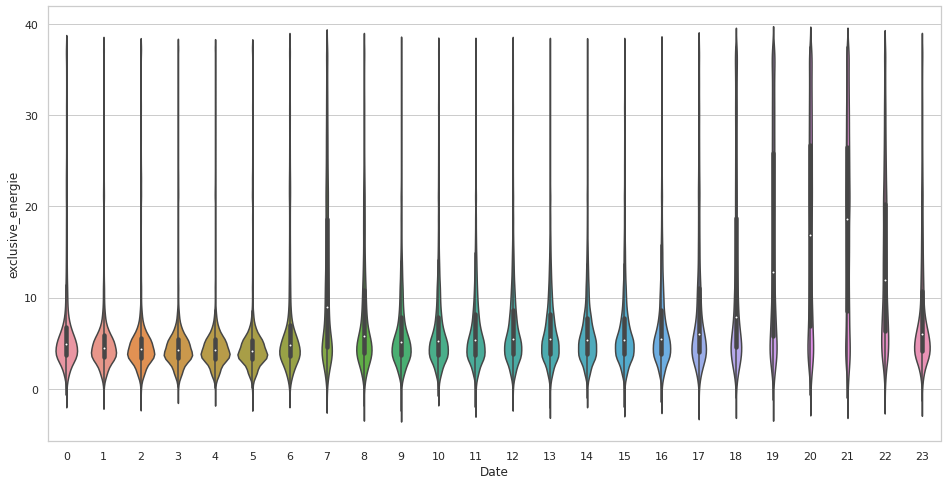

In [ ]:
#violin plot pour visualiser les données pour toute les heures de la journée
plt.figure(figsize=(16,8))
ax = sns.violinplot(x=all_pow_cons.index.hour, y="exclusive_energie", data=all_pow_cons)


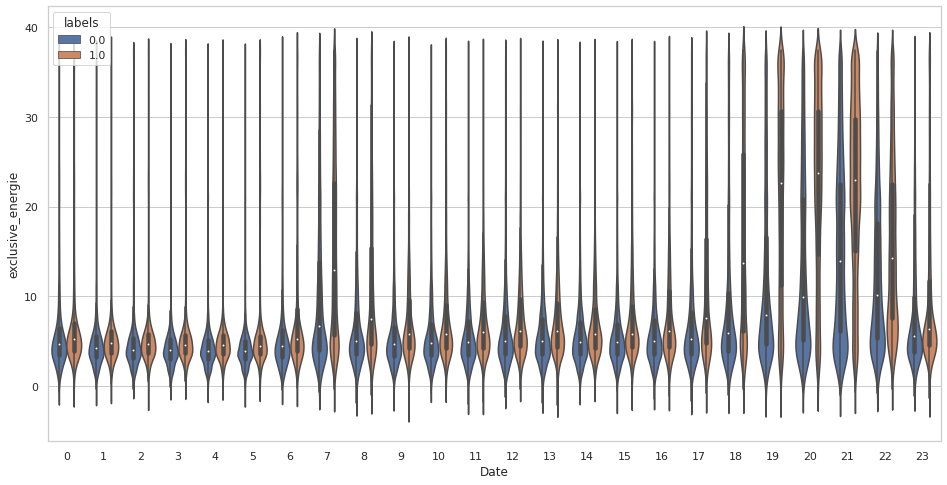

In [ ]:
#violin plot visualisation des données pour chaque heure de la journée différenciée par la saisonalité
plt.figure(figsize=(16,8))
ax = sns.violinplot(x=all_pow_cons.index.hour, y="exclusive_energie", data=all_pow_cons, hue="labels")

on remarque dejà que la consommation augmente entre 18h et 23h et en générale, elle reste autour de 5kw. en différenciant les données par saisons on se rends compte que la consommation en été est (pour la médiane) toujours inférieur à la consommation en hiver

In [ ]:
for i in range(24):
  test = stats.kstest(Y_var[i,1], 'norm')
  if (test.pvalue < 0.05):
    print('la p-valeur du test est', test.pvalue,'la distribution à ' , i ,' heure ne suit pas avec probabilité 0.05 de se tromper une loi normale')
  else:
    print('la distribution à ' , i,   'heure suit une loi normale')

la p-valeur du test est 0.0 la distribution à  0  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribution à  1  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribution à  2  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribution à  3  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribution à  4  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribution à  5  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribution à  6  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribution à  7  heure ne suit pas avec probabilité 0.05 de se tromper une loi normale
la p-valeur du test est 0.0 la distribut

le Test de kolmokorov -smirnov a été implémenté sur toute les heures de notre data de power consumption. Il a démontré avec une forte probalité que la consommation d'energie ne suit pas une distribution normale.
#### explication: 
cela s'explique par le fait que la consommation d'énergie étant autour de zeros pour certain moment de la journée change de valeur avec une très grande variance(après qu'o)

[[-19.25405903  12.55541916]
 [  4.85271678  -3.42769414]
 [-19.25405903  12.55541916]
 ...
 [ 10.93385953  31.5792526 ]
 [  3.77136069  -4.34763415]
 [ 17.33597229 -16.97894522]]
[0 0 0 ... 0 0 0]


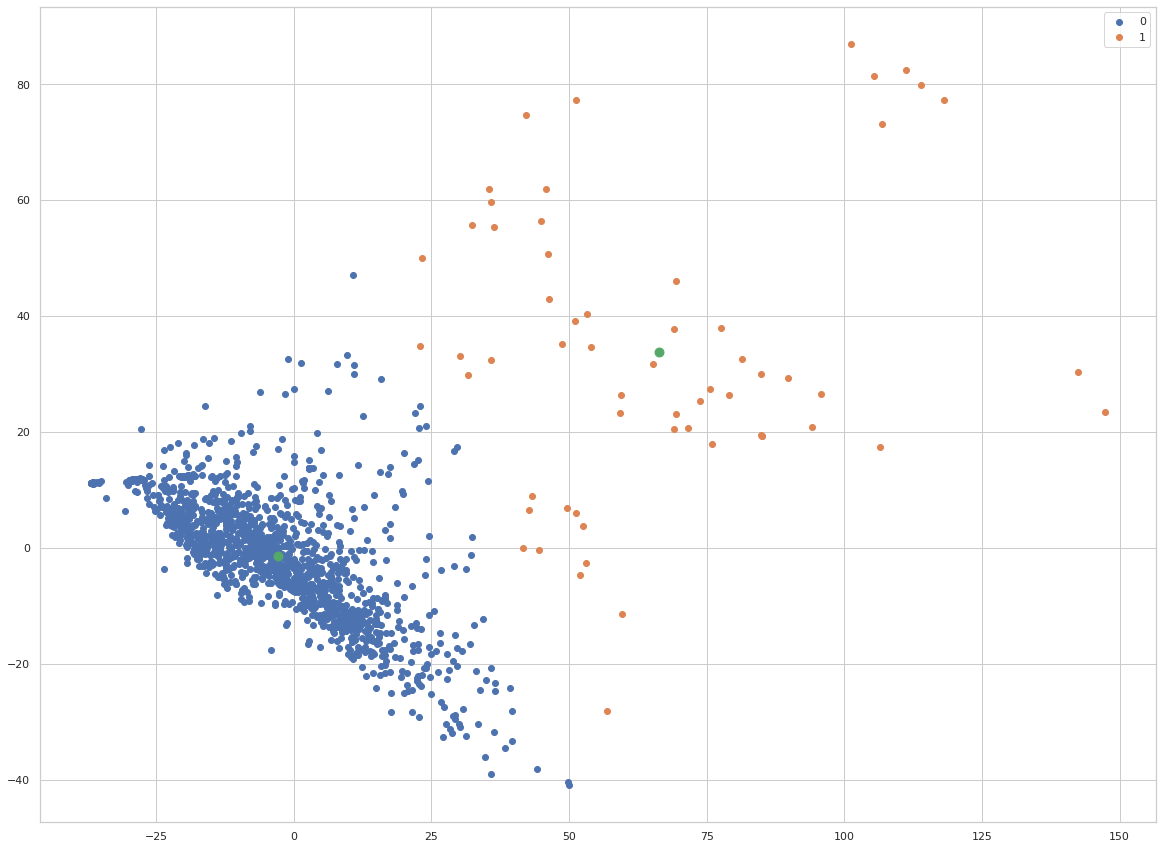

In [ ]:
pca = PCA(2)
df = pca.fit_transform(data_transformed)
print(df)
 
kmeans = KMeans(n_clusters = 2)
label = kmeans.fit_predict(df)
print(label)

#Getting unique labels
 
u_labels = np.unique(label)

#Getting the Centroids
centroids = kmeans.cluster_centers_
 
#plotting the results:

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80)
plt.legend()
plt.show()

#4- Weather Influence

Dans notre cas d'étude, on remarque que nos données ne sont pas définies avec la même période. Afin de rémédier à ce problème, deux solutions s'offrent à nous:
- soit on $Upsample$ nos données 
- Soit on $Downsample$

Etant donnée, qu'on cherche à prédire la puissance consommée, il est pertinent de faire un $Upsample$ afin que les variables explicative ont la même période que la variable de réponse. Après avoir testé $l' \ interpolation \ linéaire \ et \ polynomiale \ d'\ ordre \ 2$, nous obtenons des résultats similaires. Nous choisons ainsi, l'$approche \ linéaire$ pour son faible temps de calcul.

In [ ]:
# Interpolation lineaire pour Upsample nos données
up_all_weather= all_weather.resample('T')
up_all_weather = up_all_weather.interpolate(method='linear')
up_all_weather.head()

,pmer,tend,cod_tend,dd,ff,t,td,u
date,,,,,,,,
2007-01-01 00:00:00,101960.000000,-70.000000,6.000000,220.000000,9.800000,286.650000,284.850000,89.00
2007-01-01 00:01:00,101960.277778,-69.388889,5.983333,220.111111,9.785556,286.644444,284.835556,88.95
2007-01-01 00:02:00,101960.555556,-68.777778,5.966667,220.222222,9.771111,286.638889,284.821111,88.90
2007-01-01 00:03:00,101960.833333,-68.166667,5.950000,220.333333,9.756667,286.633333,284.806667,88.85
2007-01-01 00:04:00,101961.111111,-67.555556,5.933333,220.444444,9.742222,286.627778,284.792222,88.80


In [ ]:
exclusive_energie = pd.DataFrame(exclusive_energie)
exclusive_energie

,0
Date,
2007-01-01 00:00:00,43.000000
2007-01-01 00:01:00,42.533333
2007-01-01 00:02:00,42.500000
2007-01-01 00:03:00,42.500000
2007-01-01 00:04:00,42.566667
...,...
2010-11-26 20:58:00,15.766667
2010-11-26 20:59:00,15.733333
2010-11-26 21:00:00,15.633333


In [ ]:
exclusive_energie.rename(columns = {0 : 'energie'}, inplace= True)
exclusive_energie

,energie
Date,
2007-01-01 00:00:00,43.000000
2007-01-01 00:01:00,42.533333
2007-01-01 00:02:00,42.500000
2007-01-01 00:03:00,42.500000
2007-01-01 00:04:00,42.566667
...,...
2010-11-26 20:58:00,15.766667
2010-11-26 20:59:00,15.733333
2010-11-26 21:00:00,15.633333


In [ ]:
# concatenation pour avoir les variables explicative et de reponse dans le même dataframe
up_all_weather = up_all_weather.join(exclusive_energie, how = 'inner')

In [ ]:
up_all_weather

,pmer,tend,cod_tend,dd,ff,t,td,u,energie
2007-01-01 00:00:00,101960.000000,-70.000000,6.000000,220.000000,9.800000,286.650000,284.850000,89.000000,43.000000
2007-01-01 00:01:00,101960.277778,-69.388889,5.983333,220.111111,9.785556,286.644444,284.835556,88.950000,42.533333
2007-01-01 00:02:00,101960.555556,-68.777778,5.966667,220.222222,9.771111,286.638889,284.821111,88.900000,42.500000
2007-01-01 00:03:00,101960.833333,-68.166667,5.950000,220.333333,9.756667,286.633333,284.806667,88.850000,42.500000
2007-01-01 00:04:00,101961.111111,-67.555556,5.933333,220.444444,9.742222,286.627778,284.792222,88.800000,42.566667
...,...,...,...,...,...,...,...,...,...
2010-12-11 23:55:00,102224.166667,-149.722222,6.055556,269.444444,2.569444,277.563889,276.961111,95.972222,11.500000
2010-12-11 23:56:00,102223.333333,-149.777778,6.044444,269.555556,2.575556,277.561111,276.958889,95.977778,11.466667
2010-12-11 23:57:00,102222.500000,-149.833333,6.033333,269.666667,2.581667,277.558333,276.956667,95.983333,11.466667
2010-12-11 23:58:00,102221.666667,-149.888889,6.022222,269.777778,2.587778,277.555556,276.954444,95.988889,11.466667


In [ ]:
# Matrice de corrélation avec coefficient de Spearman
up_all_weather.corr(method = 'spearman')

,pmer,tend,cod_tend,dd,ff,t,td,u,energie
pmer,1.000000,0.056218,-0.060014,-0.053848,-0.237540,-0.062391,-0.151314,-0.129988,-0.001313
tend,0.056218,1.000000,-0.810825,0.232459,-0.009740,-0.096324,-0.010741,0.116895,0.092505
cod_tend,-0.060014,-0.810825,1.000000,-0.176602,0.011608,0.077987,0.010303,-0.089017,-0.082369
dd,-0.053848,0.232459,-0.176602,1.000000,0.065817,0.066173,0.124098,0.061093,-0.017755
ff,-0.237540,-0.009740,0.011608,0.065817,1.000000,0.086633,-0.009725,-0.234745,0.011406
t,-0.062391,-0.096324,0.077987,0.066173,0.086633,1.000000,0.840507,-0.553975,-0.162421
td,-0.151314,-0.010741,0.010303,0.124098,-0.009725,0.840507,1.000000,-0.084678,-0.159833
u,-0.129988,0.116895,-0.089017,0.061093,-0.234745,-0.553975,-0.084678,1.000000,0.044616
energie,-0.001313,0.092505,-0.082369,-0.017755,0.011406,-0.162421,-0.159833,0.044616,1.000000


In [ ]:
# Matrice de Covariance
up_all_weather.cov()

,pmer,tend,cod_tend,dd,ff,t,td,u,energie
pmer,897952.452283,7289.607811,-134.850551,-8781.592495,-480.949399,-237.022721,-672.250763,-2148.473324,96.002686
tend,7289.607811,14254.915867,-203.981657,2207.718405,-3.006808,-77.963168,-5.987359,256.117733,111.925701
cod_tend,-134.850551,-203.981657,5.728764,-34.881044,0.092443,1.539894,0.055956,-5.313115,-2.389108
dd,-8781.592495,2207.718405,-34.881044,9659.447450,13.156216,52.126312,89.289938,168.663029,-7.127883
ff,-480.949399,-3.006808,0.092443,13.156216,3.989178,1.014511,-0.284967,-6.463405,-0.266050
t,-237.022721,-77.963168,1.539894,52.126312,1.014511,50.670192,33.092852,-68.067043,-9.438712
td,-672.250763,-5.987359,0.055956,89.289938,-0.284967,33.092852,31.155842,-3.782333,-5.701922
u,-2148.473324,256.117733,-5.313115,168.663029,-6.463405,-68.067043,-3.782333,272.995081,14.261340
energie,96.002686,111.925701,-2.389108,-7.127883,-0.266050,-9.438712,-5.701922,14.261340,88.368315


In [ ]:
up_all_weather

,pmer,tend,cod_tend,dd,ff,t,td,u,energie
2007-01-01 00:00:00,101960.000000,-70.000000,6.000000,220.000000,9.800000,286.650000,284.850000,89.000000,43.000000
2007-01-01 00:01:00,101960.277778,-69.388889,5.983333,220.111111,9.785556,286.644444,284.835556,88.950000,42.533333
2007-01-01 00:02:00,101960.555556,-68.777778,5.966667,220.222222,9.771111,286.638889,284.821111,88.900000,42.500000
2007-01-01 00:03:00,101960.833333,-68.166667,5.950000,220.333333,9.756667,286.633333,284.806667,88.850000,42.500000
2007-01-01 00:04:00,101961.111111,-67.555556,5.933333,220.444444,9.742222,286.627778,284.792222,88.800000,42.566667
...,...,...,...,...,...,...,...,...,...
2010-12-11 23:55:00,102224.166667,-149.722222,6.055556,269.444444,2.569444,277.563889,276.961111,95.972222,11.500000
2010-12-11 23:56:00,102223.333333,-149.777778,6.044444,269.555556,2.575556,277.561111,276.958889,95.977778,11.466667
2010-12-11 23:57:00,102222.500000,-149.833333,6.033333,269.666667,2.581667,277.558333,276.956667,95.983333,11.466667
2010-12-11 23:58:00,102221.666667,-149.888889,6.022222,269.777778,2.587778,277.555556,276.954444,95.988889,11.466667


Nous allons maintenant procéder à des test statistiques pour déterminer s'il y'a relation ou pas entre les variables explicatives et de réponses. L'hypothèse nulle du test est $ r = 0$, où $r$ est le coeff de corrélation.

In [ ]:
p_value =[]
for name_ in up_all_weather.columns:
  p_value.append(stats.spearmanr(up_all_weather[name_], up_all_weather['energie']))


In [ ]:
p_value

[SpearmanrResult(correlation=-0.001312831492962219, pvalue=0.05994693862150105),
 SpearmanrResult(correlation=0.09250492483173285, pvalue=0.0),
 SpearmanrResult(correlation=-0.08236943612165197, pvalue=0.0),
 SpearmanrResult(correlation=-0.01775502848193318, pvalue=8.321725817601187e-143),
 SpearmanrResult(correlation=0.01140586780557357, pvalue=4.7816732988269514e-60),
 SpearmanrResult(correlation=-0.16242068544754867, pvalue=0.0),
 SpearmanrResult(correlation=-0.15983306528106545, pvalue=0.0),
 SpearmanrResult(correlation=0.044616066053220146, pvalue=0.0),
 SpearmanrResult(correlation=1.0, pvalue=0.0)]

Si l'on observe les $p-valeur$ ainsi affichées, Dans tous les cas (sauf pour la la variable $pmer$), il y'a moins de $5\%$  de probabilité que l'hypothèse nulle soit correcte. Dans le cas de la variable $pmer$, on $ échoue \ de \  rejetter \ l'\ hypothèse \ nulle.$ les variables $t : température$ et $tend :Dew point $ étant les plus corrélées à l $énergie$.

### Prédiction

Nous allons utiliser $RandomForest$, $LinearRegression$

In [ ]:
X_train = up_all_weather['2007':'2009'].drop(['energie'], axis = 1)
y_train = up_all_weather['2007': '2009']['energie']
X_test = up_all_weather['2010':].drop(['energie'], axis = 1)
y_test = up_all_weather['2010': ]['energie']

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 20)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
print(rf.score(X_train, y_train))

0.9908703089077074


In [ ]:
y_pred = rf.predict(X_test)

In [ ]:
print(rf.score(X_test, y_test))

NameError: ignored

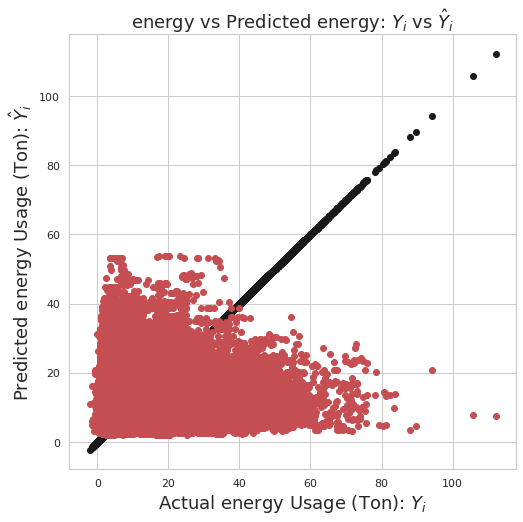

In [ ]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test, c='k')
plt.scatter(y_test, y_pred, c='r')
plt.xlabel('Actual energy Usage (Ton): $Y_i$',fontsize=18)
plt.ylabel("Predicted energy Usage (Ton): $\hat{Y}_i$",fontsize=18)
plt.title("energy vs Predicted energy: $Y_i$ vs $\hat{Y}_i$",fontsize=18)
plt.show()

# Linear regression

In [ ]:
X_train_= sm.add_constant(X_train)
linear_model = sm.OLS(y_train, X_train).fit()
print(linear_model.summary())
y_pred_lin = linear_model.predict(X_test)

                                 OLS Regression Results                                
Dep. Variable:                energie   R-squared (uncentered):                   0.494
Model:                            OLS   Adj. R-squared (uncentered):              0.494
Method:                 Least Squares   F-statistic:                          1.924e+05
Date:                Thu, 20 May 2021   Prob (F-statistic):                        0.00
Time:                        16:26:03   Log-Likelihood:                     -5.8259e+06
No. Observations:             1578240   AIC:                                  1.165e+07
Df Residuals:                 1578232   BIC:                                  1.165e+07
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

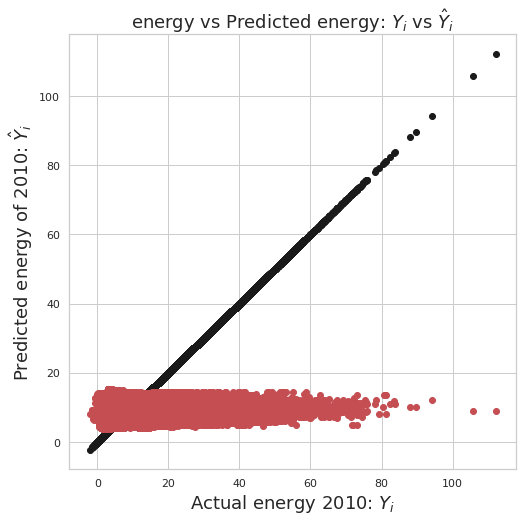

In [ ]:
#Plot actual vs. prediced usage.
fig = plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test, c='k')
plt.scatter(y_test, y_pred_lin, c='r')
plt.xlabel('Actual energy 2010: $Y_i$',fontsize=18)
plt.ylabel("Predicted energy of 2010: $\hat{Y}_i$",fontsize=18)
plt.title("energy vs Predicted energy: $Y_i$ vs $\hat{Y}_i$",fontsize=18)
plt.show()

A partir des resultats obtenus, on ne trouve pas une relation significative entre les données météorologiques et la consommation d'électricité. Cela pourrait être dû à l'insuffisance des données en elles même qui n'apporte pas assez d'information. Notre recommendation est donc d'augmenter le nombre de données (moins corrolées ou presque indépendants) et de refaire l'expérience.